<a href="https://colab.research.google.com/github/philshiu/fly-appendage-tracking/blob/main/Tracking_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we analyze the tracked videos, and compare the different phenotypes to each other.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Create a list of all the neurons we will analyze by analyzing the file directory containing the tracked videos.

In [ ]:
import os
import re

#The output of the tracking analysis is a set of .h5 files. We process these here.
foldername = '/content/drive/My Drive/Movies_proboscis_extension/All_h5_files'
filearray = os.listdir(foldername)

neuron_files = [] #A list of all the tracked video files.
for i in filearray:
  m = re.search('(.*)_(.+)DLC_resnet_50_Combined_unix_filesJan30shuffle1_550000\.h5', i)
  if m:
    neuron_files.append(m.group(1))

#Create a dictoary of the neuro video files
neuron_vid_data = dict()
for neuron in neuron_files:
  if neuron in neuron_vid_data.keys():
    neuron_vid_data[neuron]["number_of_files"] = neuron_vid_data[neuron]["number_of_files"] + 1
  else:
    neuron_vid_data[neuron] = dict()
    neuron_vid_data[neuron]["frame_rate"] = 30
    neuron_vid_data[neuron]["number_of_files"] = 1
neuron_vid_data
list_of_neurons = list(neuron_vid_data.keys())


In [ ]:
!pip install pca

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=8fd9dc875d618d73c558a821d38ec7654733a85719aa09374037fd9220126e22
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


Load libraries, and define helper functions

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from pca import pca as pca_program
from collections import namedtuple
from scipy.spatial import distance
from sklearn.utils import resample

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.cluster import KMeans

%matplotlib notebook

def calcAngle (a, b, c, on_right_side):
    '''
    Takes three numpy arrays (a, b, c) and returns their angle between them, with b as the middle value
    Returns the value in degrees.
    It is important we maintain the orientation, that is, differentiate between 90 and 270 degrees.
    on_right_side is a boolean that is true if the fly's head is on the right side.  If not, the fly
    is a mirror image and the angle value must be "flipped," ie., 360 - angle
    Args:
      a, b, c: numpy arrays.
      on_right_side: a boolean that is true, if the fly's head is on the right side in the original video.
    Returns:
      The angle between the vectors.
    '''
    if (a == b).all() or (c == b).all() or (c == a).all(): # Test if any of the points are the same.
        return np.nan
    ab = a - b
    bc = c - b
    cosine_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    # We need to determine if the angle exceeds 180.
    left_or_right = (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])
    if left_or_right < 0:
        if on_right_side:
            return np.degrees(angle)
        else:
            return 360 - np.degrees(angle)
    if left_or_right > 0:
        if on_right_side:
            return 360 - np.degrees(angle)
        else:
            return np.degrees(angle)
    else:
        return np.nan
    
def calculate_angles_of_list_of_points(x1, y1, x2, y2, x3, y3, on_right_side):
    '''Calculates the angle between a lists of points. This function assumes each set of points have the same number of values (ie., length).
        Args:
             x1, y1, x2, y2, x3, y3: list of points.
             on_right_side: a boolean that is true, if the fly's head is on the right side in the original video.
        Returns:
              A list of angle between the points.
    '''
    angles = []
    for i in range(len(x1)):
        value = calcAngle(np.array([x1[i], y1[i]]), np.array([x2[i], y2[i]]), np.array([x3[i], y3[i]]), on_right_side)
        angles.append(value)
    return angles

def calculate_length_between_points(x1, y1, x2, y2):
    '''Calculate the distance between points
       We assume all the vectors are the same length
       Args:
            x1, y1, x2, y2: Lists of points
       Returns:
            A list of distances
    '''
    lengths = []
    for i in range(len(x1)):
        value = np.linalg.norm(np.array([x1[i], y1[i]]) - np.array([x2[i], y2[i]]))
        lengths.append(value)
    return lengths

def resize_array(array, intended_length):
    '''
    Takes numpy array and linearly resizes it, interpolating values as necessary.
    '''
    arr_interp = interp.interp1d(np.arange(array.size), array)
    return arr_interp(np.linspace(0, array.size-1, intended_length))

def remove_extreme_values (Dataframe_to_clean, to_clean_x = 'FrontEyex', to_clean_y = 'FrontEyey'):
    '''Removes extreme values from a dataframe. For example, if the tracking network performs poorly,
       there can be large "jumps", far from the median point of this value, that we wish to exclude.
       Args:
            Dataframe_to_clean: A dataframe containing the tracked points.
            to_clean_x, to_clean_y: strings specifying what body parts should be cleaned.
      Returns:
            A dataframe with extreme values removed.
    '''
    too_large_distance = 150 #Value in pixels; this is a large jump in the video space.
    # Identify the median_x and y values.  Note that this is not necessarily the median point, since these two values are independently chosen.
    median_x = Dataframe_to_clean[to_clean_x].median()
    median_y= Dataframe_to_clean[to_clean_y].median()
    standard_deviation =  ((Dataframe_to_clean[to_clean_x].std() ** 2) + (Dataframe_to_clean[to_clean_y].std() ** 2) ** .5)
    # Choose an appropriate filtering distance.  If point doesn't move much, choose a more narrow filtering distance.
    if standard_deviation  * 5 < too_large_distance:
        too_large_distance = standard_deviation * 5

    # Go through each of the points, and test if the point is excessively far from the median value.
    Dataframe_to_clean["Extreme_Values"] = (((Dataframe_to_clean[to_clean_x] - median_x) ** 2 + (Dataframe_to_clean[to_clean_y] - median_y) ** 2) ** .5) > too_large_distance
    # Go through and remove these values, then linearly interpolate them.
    Dataframe_to_clean[to_clean_x] = np.where((Dataframe_to_clean['Extreme_Values'] == True), np.nan, Dataframe_to_clean[to_clean_x])
    Dataframe_to_clean[to_clean_y] = np.where((Dataframe_to_clean['Extreme_Values'] == True), np.nan, Dataframe_to_clean[to_clean_y])
    new_dataframe = Dataframe_to_clean.interpolate(method = 'linear').drop('Extreme_Values', axis =1)
    #It is possible that the first value(s) are not replaced, since linear interpolation can't handle that.  If so, replace these values
    #with the first good values
    if new_dataframe.isnull().values.any():
        new_dataframe = new_dataframe.fillna(method = 'backfill')
    return new_dataframe

def filter_jumps(data_frame, values_to_filter = ['FrontLabellum', 'FrontEye', 'UnderMaxPalp'], distance_too_far = 50):
    '''Removes extreme values from a dataframe. For example, if the tracking network performs poorly,
       there can be large "jumps". This removes places where the point immediately jumps from one point to another.
       This function assumes the first point in the movie is not an outlier.
       Args:
            data_frame: A dataframe containing the tracked points.
            values_to_filter: strings specifying what body parts should be cleaned.
            distance_too_far: A value, in pixels, indicating how large of a jump is too extreme.
      Returns:
            A dataframe with extreme values removed.
    '''
    new_data_frame = data_frame.copy()
    for value in values_to_filter:
        x_value = value + 'x'
        y_value = value + 'y'
        last_good_x = new_data_frame.loc[0, x_value]
        last_good_y = new_data_frame.loc[0, y_value]
        for i in range(len(data_frame[x_value])):
            distance_from_last = np.abs(distance.euclidean([data_frame.loc[i, x_value], data_frame.loc[i, y_value]], [last_good_x, last_good_y]))
            if distance_from_last > distance_too_far:
                #Replace these values if the point jumped too far from the last frame.
                new_data_frame.loc[i, x_value] = last_good_x
                new_data_frame.loc[i, y_value] = last_good_y
            else:
                #Otherwise, set the newest point as the new "last_good" value.
                last_good_x = new_data_frame.loc[i, x_value]
                last_good_y = new_data_frame.loc[i, y_value]
    return new_data_frame

def get_clean_dataframe(path, bodyparts = ('FrontLabellum', 'FrontEye', 'UnderMaxPalp', 'TopEye', 'MaxPalp', 'BottomLabellum', 'TopRostrum')):
    # This takes the dataframe generated by DeepLabCut and converts it into a slightly simpler one.
    Dataframe = pd.read_hdf(path)
    #Get the value of scorer.
    DLCscorer = Dataframe.keys()[0][0]
    data = pd.DataFrame()
    
    for bodypart in bodyparts:
        data[bodypart + 'x']=Dataframe[DLCscorer][bodypart]['x']
        data[bodypart + 'y']=Dataframe[DLCscorer][bodypart]['y']

    return data

def recenter_values(dataframe, bodyparts =('FrontLabellum', 'FrontEye', 'UnderMaxPalp', 'TopEye', 'MaxPalp', 'BottomLabellum', 'TopRostrum'), center = 'UnderMaxPalp'):
    """ Takes a dataframe and returns a new dataframe with recentered values.
    Defaults to centering around the maxpalp value.
    """
    new_dataframe = dataframe.copy()
    for bodypart in bodyparts:
        new_dataframe['Recentered' + bodypart + 'x'+ ''] = new_dataframe[bodypart + 'x'] - new_dataframe[center + 'x']
        new_dataframe['Recentered' + bodypart + 'y'+ ''] = new_dataframe[bodypart + 'y'] - new_dataframe[center + 'y']
    return new_dataframe

NUM_BOOTSTRAP_SAMPLES = 100
def bootstrap(data):
  bootstrap = []
  for i in range(NUM_BOOTSTRAP_SAMPLES):
      np.random.seed(i)
      bootstrap.append((resample(data)))
  return bootstrap

flatten = lambda t: [item for sublist in t for item in sublist]

def build_CI_barplot(bootstrapped, CI, y_label, title, neuron_list):
  '''
    Generates a 95% confidence interval barplot
  '''
  data = [np.mean(neuron, axis = 1) for neuron in bootstrapped]

  neuron_mapping = []
  for i in range(len(data)):
    for duration in data[i]:
      neuron_mapping.append(neuron_list[i])
  neuron_mapping

  #build sorted index
  mean_data = np.mean(data, axis = 1)
  print(min(mean_data))
  print(max(mean_data))
  data_df = pd.DataFrame(mean_data, index=neuron_list, columns=["y_label"])
  sorted_data = data_df.sort_values(by=["y_label"])
  print(data_df)

  mean_ext_dur_df = pd.DataFrame({'Neuron': neuron_mapping, y_label: flatten(data)})
  fig = plt.figure(figsize=(30, 10))
  ax = sns.barplot(x='Neuron', y=y_label,data=mean_ext_dur_df, ci=95, order=sorted_data.index)
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical', fontsize=10)
  plt.title(title)
  plt.show()

  fig = plt.figure(figsize=(20, 20))
  ax = sns.boxplot(x='Neuron', y=y_label,data=mean_ext_dur_df, order=sorted_data.index)
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical', fontsize=10)
  plt.title(title)
  plt.show()

def build_std_dev_barplot(data, y_label, title, neuron_list):
  neuron_mapping = []
  for i in range(len(data)):
    for data_point in data[i]:
      neuron_mapping.append(neuron_list[i])

  #build sorted index
  mean_data = [np.mean(neuron) for neuron in data]
  data_df = pd.DataFrame(mean_data, index=neuron_list, columns=["y_label"])
  sorted_data = data_df.sort_values(by=["y_label"])

  median_data = [np.median(neuron) for neuron in data]
  data_df = pd.DataFrame(median_data, index=neuron_list, columns=["y_label"])
  sorted_med_data = data_df.sort_values(by=["y_label"])

  mean_ext_dur_df = pd.DataFrame({'Neuron': neuron_mapping, y_label: flatten(data)})
  fig = plt.figure(figsize=(30, 10))
  ax = sns.barplot(x='Neuron', y=y_label,data=mean_ext_dur_df, ci="sd", order=sorted_data.index)
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical', fontsize=10)
  plt.title(title)
  plt.show()

  fig = plt.figure(figsize=(20, 20))
  ax = sns.boxplot(x='Neuron', y=y_label,data=mean_ext_dur_df, order=sorted_med_data.index)
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical', fontsize=10)
  plt.title(title)
  plt.show()

def calc_distance_between_points_in_a_vector_2d(v1):
    '''calc_distance_between_points_in_a_vector_2d [for each consecutive pair of points, p1-p2, in a vector, get euclidian distance]
    This function can be used to calculate the velocity in pixel/frame from tracking data (X,Y coordinates)
    
    Arguments:
        v1 {[np.array]} -- [2d array, X,Y position at various timepoints]
    
    Raises:
        ValueError
    
    Returns:
        [np.array] -- [1d array with distance at each timepoint]
    >>> v1 = [0, 10, 25, 50, 100]
    >>> d = calc_distance_between_points_in_a_vector_2d(v1)
    '''
    # Check data format
    if isinstance(v1, dict) or not np.any(v1) or v1 is None:
            raise ValueError(
                'Feature not implemented: cant handle with data format passed to this function')

    # If pandas series were passed, try to get numpy arrays
    try:
        v1, v2 = v1.values, v2.values
    except:  # all good
        pass
    # loop over each pair of points and extract distances
    dist = []
    for n, pos in enumerate(v1):
        # Get a pair of points
        if n == 0:  # get the position at time 0, velocity is 0
            p0 = pos
            dist.append(0)
        else:
            p1 = pos  # get position at current frame

            # Calc distance
            dist.append(np.abs(distance.euclidean(p0, p1)))

            # Prepare for next iteration, current position becomes the old one and repeat
            p0 = p1

    return np.array(dist)

In [ ]:
def analyze_file(name_of_file, create_labelled_movie = False):
    '''Analyzes the DeepLabCut data. Creates a labelled movie of the points, if desired.
       Args:
          name_of_file: path to the DeepLabCut .h5 file.
          create_labelled_movie: boolean of whether to output a labelled movie
       Returns:
          A dictonary containing a set of calculated values that we care about, for this video.
    '''

    # These are the labellum bodyparts that will be analyzed.
    bodyparts = ('FrontLabellum', 'FrontEye', 'UnderMaxPalp', 'BottomLabellum')
    bpt, bpt1, bpt2, bpt3 = bodyparts
    
    # We open up the saved data and put it into a pandas dataframe.
    CleanData = get_clean_dataframe(name_of_file, bodyparts)

    # Remove extreme values
    for body_part in bodyparts:
      CleanerData = remove_extreme_values(CleanData, to_clean_x = body_part + 'x', to_clean_y = body_part + 'y')
      CleanData = CleanerData

    # Filter frames where a point jumps more than jump_distance
    CleanerData = filter_jumps(CleanerData, distance_too_far = 75)

    # We need to figure out if the fly's head is on the left side or right side, so the angles calculated are correct.
    on_right_side= True
    if CleanerData["FrontEyex"][0] < 512: #512 is halfway point of the video image
        on_right_side = False

    # Extract the data as lists.
    labx= list(CleanerData.loc[:, bpt + 'x'])
    laby= list(CleanerData.loc[:, bpt + 'y'])
    
    eyex= list(CleanerData.loc[:, bpt1 + 'x'])
    eyey= list(CleanerData.loc[:, bpt1 + 'y'])
    
    UnderMaxPalpx= list(CleanerData.loc[:, bpt2 + 'x'])
    UnderMaxPalpy= list(CleanerData.loc[:, bpt2 + 'y'])

    BottomLabellumx= list(CleanerData.loc[:, bpt3 + 'x'])
    BottomLabellumy= list(CleanerData.loc[:, bpt3 + 'y'])
    
    value_of_angles = calculate_angles_of_list_of_points(labx, laby, UnderMaxPalpx, UnderMaxPalpy, eyex, eyey, on_right_side)

    # Get rid of NaNs!  This occurs if the two of the points are at the same location.
    for i in range(len(value_of_angles)):
        if math.isnan(value_of_angles[i]) or value_of_angles[i] == np.nan:
            # Replace that NaN with the previous value
            value_of_angles[i]=value_of_angles[i-1]
    value_of_lengths = calculate_length_between_points(labx, laby, eyex, eyey)
    eye_to_maxpalp = calculate_length_between_points(UnderMaxPalpx, UnderMaxPalpy, eyex, eyey)
    maxpalp_to_labellum = calculate_length_between_points(BottomLabellumx, BottomLabellumy, UnderMaxPalpx, UnderMaxPalpy)
    print(name_of_file)
    
    ### We now are going to make an output video, if specified    
    if create_labelled_movie:
        size_of_circles = 12
        number_of_different_colored_circles = 1
        make_labelled_video(filepath, name_of_file, labx, laby, number_of_different_colored_circles, size_of_circles)
    
    # Calculate a list of instantaneous velocities, of the distance between labellum and front of eye
    # This needs to be corrected for frame rate!
    vel = calc_distance_between_points_in_a_vector_2d(np.vstack([np.array(labx)-np.array(eyex), np.array(laby)-np.array(eyey)]).T)
    vel_eye = vel = calc_distance_between_points_in_a_vector_2d(np.vstack([np.array(labx), np.array(laby)]).T)
    results = {'vel':vel, 'vel_eye':vel_eye, 'value_of_angles':value_of_angles,
               'value_of_lengths':value_of_lengths, 'labx':labx, 'laby':laby,
               'eyex':eyex, 'eyey':eyey, 'UnderMaxPalpx':UnderMaxPalpx, 'UnderMaxPalpy':UnderMaxPalpy, 'eye_to_maxpalp': eye_to_maxpalp, 
               'maxpalp_to_labellum': maxpalp_to_labellum, 'CleanData':CleanData
               }
    return results

Analyze all the files

In [ ]:
# Analyze all the video .h5 files
%matplotlib inline
set_of_neuron_files_to_exclude = {}

agg_dist_per_fly = [ [] for neuron in list_of_neurons]
agg_ang_per_fly = [ [] for neuron in list_of_neurons]
agg_vel_per_fly = [ [] for neuron in list_of_neurons]
agg_maxpalp_to_labellum_per_fly = [ [] for neuron in list_of_neurons]
agg_eye_to_maxpalp_per_fly = [ [] for neuron in list_of_neurons]
aggregate_distances = [ [] for neuron in list_of_neurons]
aggregate_angles = [ [] for neuron in list_of_neurons]
aggregate_velocities = [ [] for neuron in list_of_neurons]

# for each neuron, add the analyzed data.
for neuron_number in range(len(list_of_neurons)):
    number_of_files = neuron_vid_data[list_of_neurons[neuron_number]]["number_of_files"]  
    frame_rate = neuron_vid_data[list_of_neurons[neuron_number]]["frame_rate"]
    for video in range(1, number_of_files+1): 
        #These values will depend on where the h5 files are saved.
        filename = r'/content/drive/My Drive/Movies_proboscis_extension/All_h5_files/{}_{}DLC_resnet_50_Combined_unix_filesJan30shuffle1_550000.h5'.format(list_of_neurons[neuron_number], video)
        if filename in set_of_neuron_files_to_exclude:
          continue
        Dataframe = pd.read_hdf(filename)
        result = analyze_file(filename)
        # Adjust the velocity vector by frame rate
        frame_rate_adjusted_velocity = result['vel'] * frame_rate
        # Add the values to the appropriate array.
        aggregate_distances[neuron_number].extend(result['value_of_lengths'])
        agg_dist_per_fly[neuron_number].append(result['value_of_lengths'])
        aggregate_angles[neuron_number].extend(result['value_of_angles'])
        agg_ang_per_fly[neuron_number].append(result['value_of_angles'])
        agg_maxpalp_to_labellum_per_fly[neuron_number].append(result['maxpalp_to_labellum'])
        agg_eye_to_maxpalp_per_fly[neuron_number].append(result['eye_to_maxpalp'])
        aggregate_velocities[neuron_number].extend(frame_rate_adjusted_velocity)
        agg_vel_per_fly[neuron_number].append(frame_rate_adjusted_velocity)
        

False
/content/drive/My Drive/Movies_proboscis_extension/All_h5_files/SS1575_1DLC_resnet_50_Combined_unix_filesJan30shuffle1_550000.h5
False
/content/drive/My Drive/Movies_proboscis_extension/All_h5_files/SS1575_2DLC_resnet_50_Combined_unix_filesJan30shuffle1_550000.h5
False
/content/drive/My Drive/Movies_proboscis_extension/All_h5_files/SS1575_3DLC_resnet_50_Combined_unix_filesJan30shuffle1_550000.h5
True
/content/drive/My Drive/Movies_proboscis_extension/All_h5_files/SS1575_4DLC_resnet_50_Combined_unix_filesJan30shuffle1_550000.h5
False
/content/drive/My Drive/Movies_proboscis_extension/All_h5_files/SS1575_5DLC_resnet_50_Combined_unix_filesJan30shuffle1_550000.h5
True
/content/drive/My Drive/Movies_proboscis_extension/All_h5_files/SS1575_6DLC_resnet_50_Combined_unix_filesJan30shuffle1_550000.h5
True
/content/drive/My Drive/Movies_proboscis_extension/All_h5_files/SS1575_7DLC_resnet_50_Combined_unix_filesJan30shuffle1_550000.h5
True
/content/drive/My Drive/Movies_proboscis_extension/Al

Plot the distribution of the angle of the extended proboscis for every neuron.

SS1575


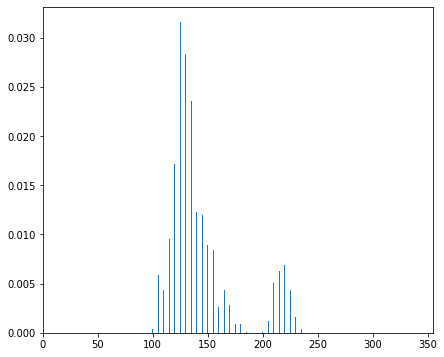

513


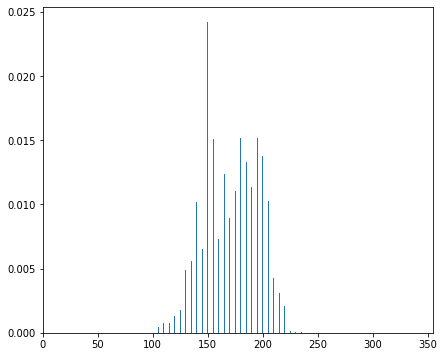

Gr66a


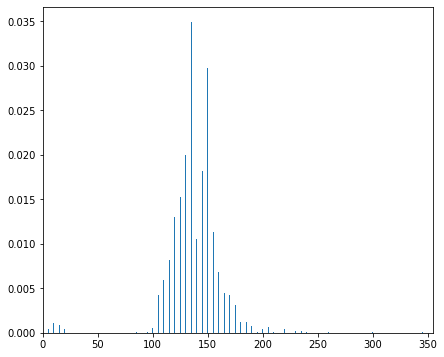

463


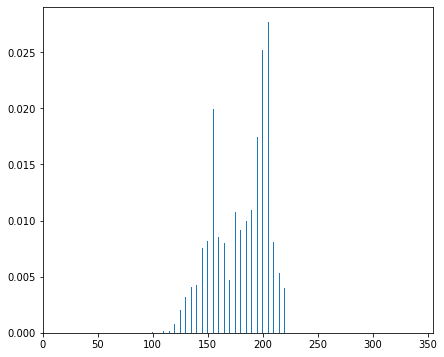

NP1562


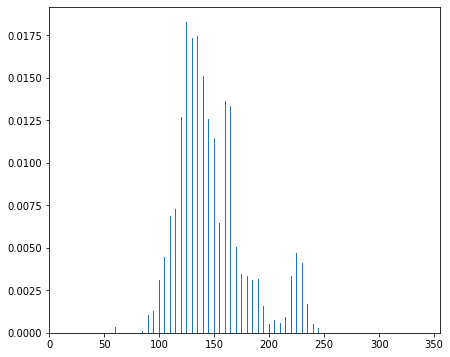

93


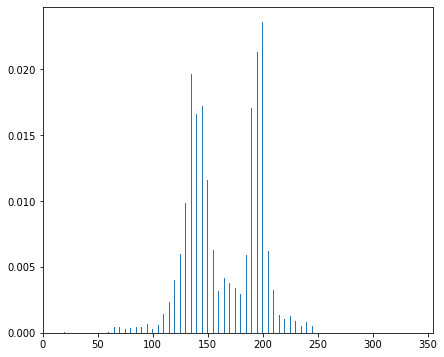

249


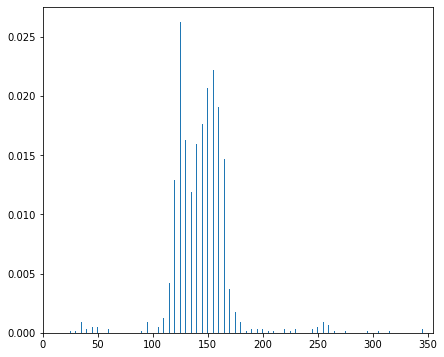

Gr64f


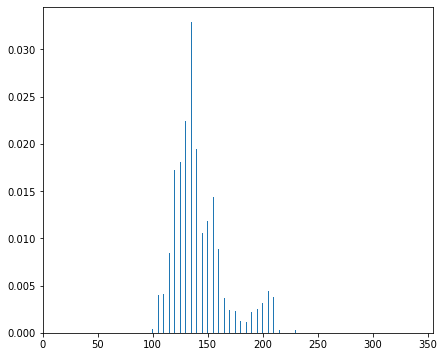

480


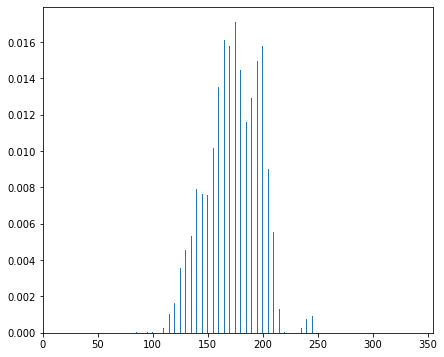

124


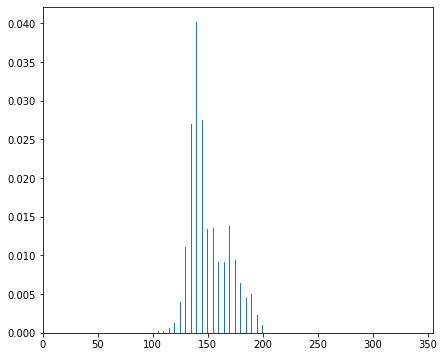

154


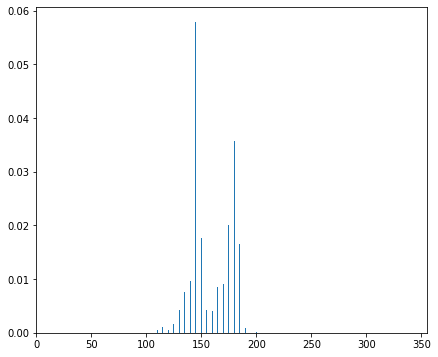

545


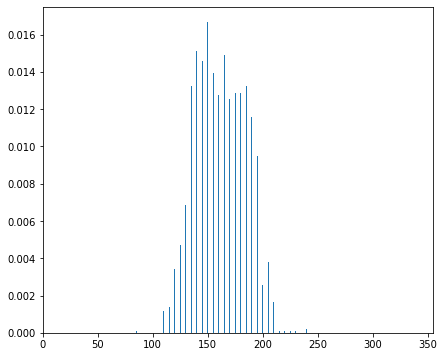

115


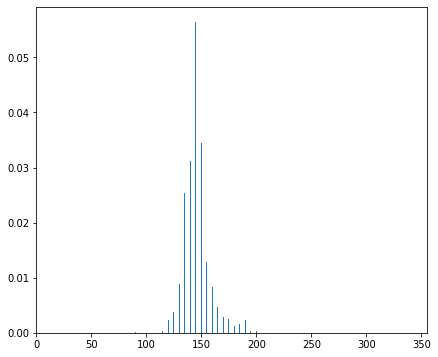

503


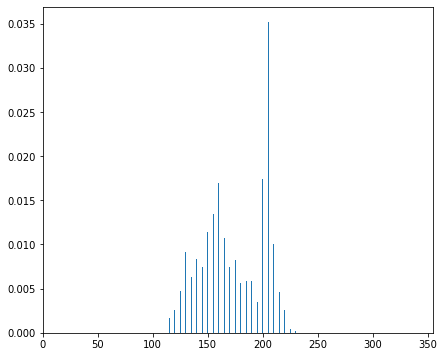

501


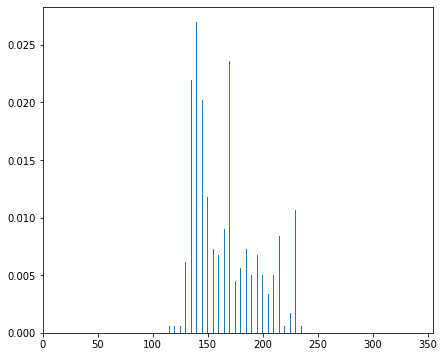

493


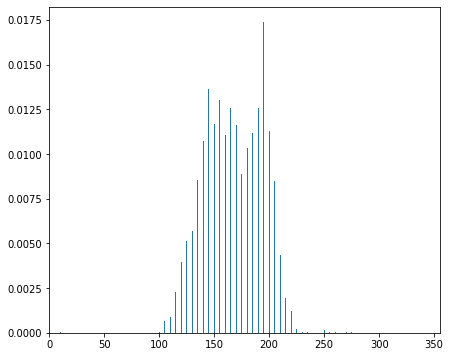

98


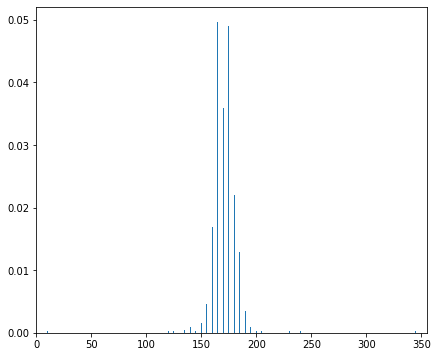

119


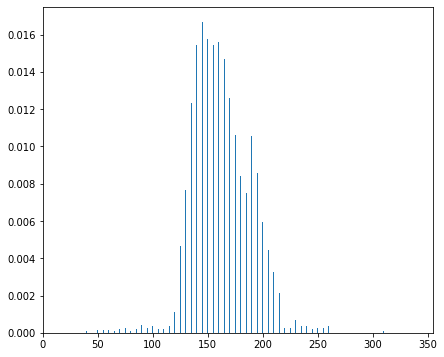

43


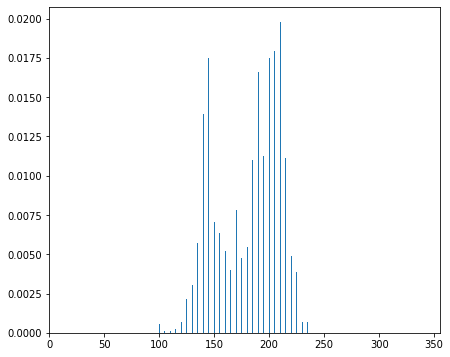

NP1562Scr


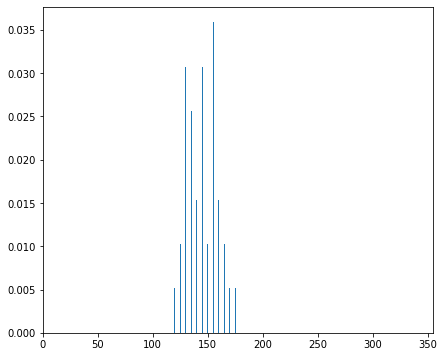

208


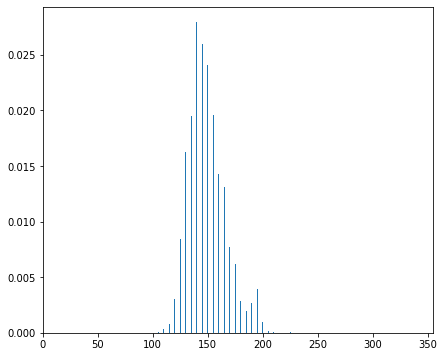

41


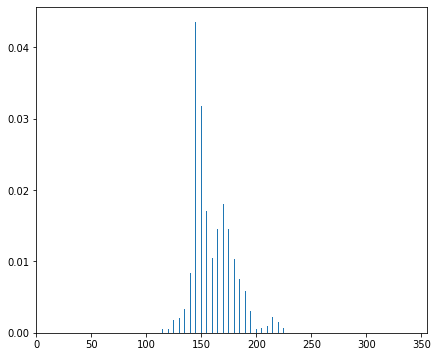

129


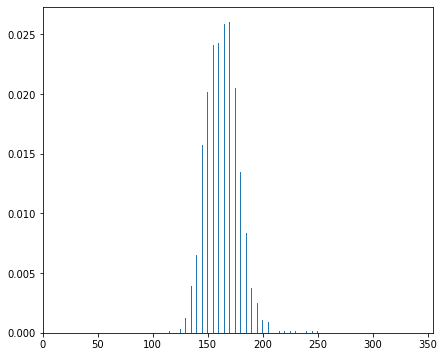

NP1562Cx


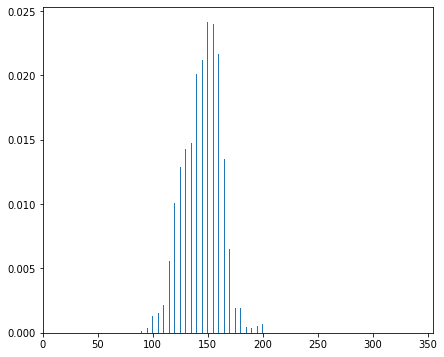

46


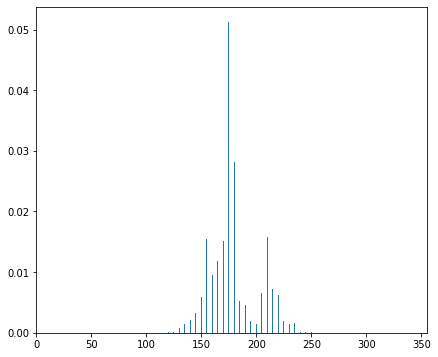

NP1562Dfd


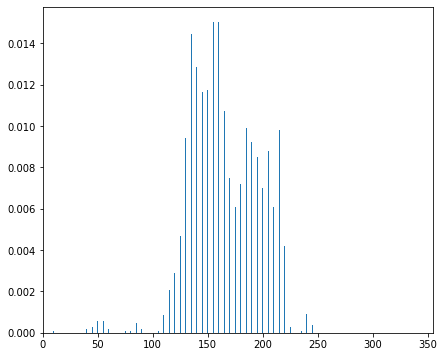

161


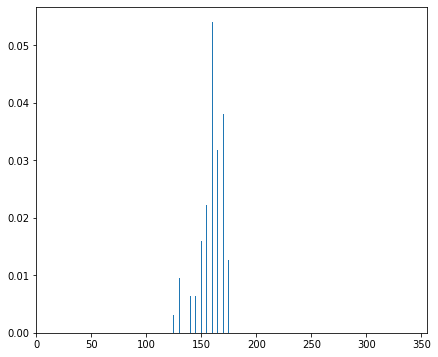

87


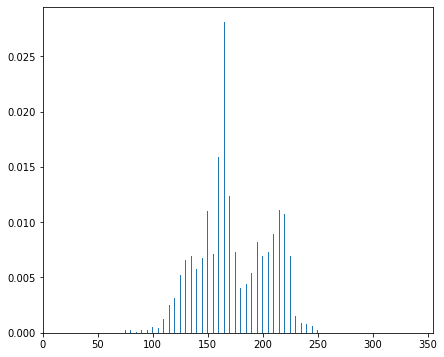

546


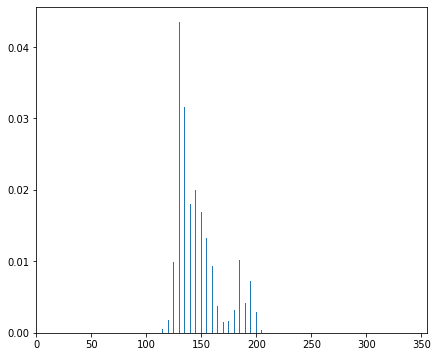

123


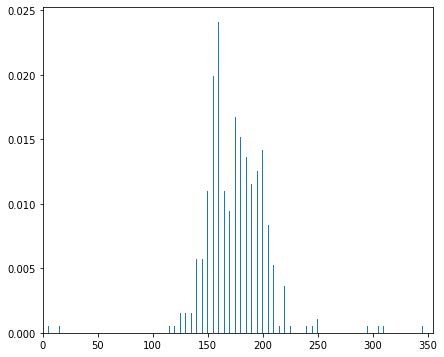

162


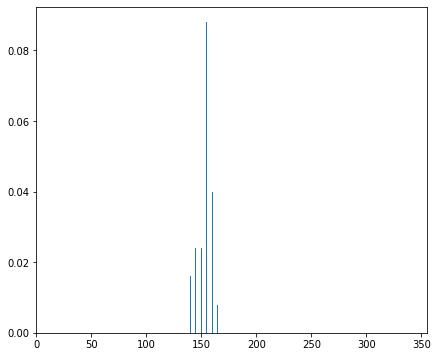

132


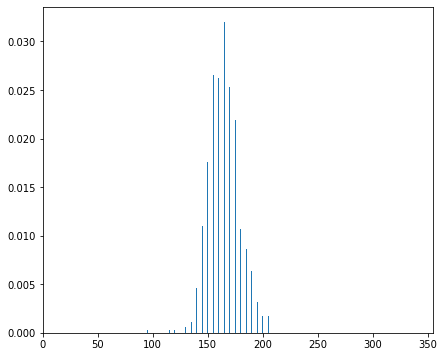

462


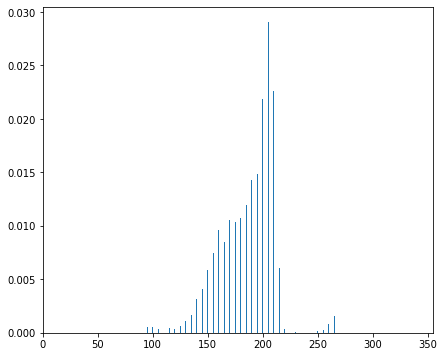

364


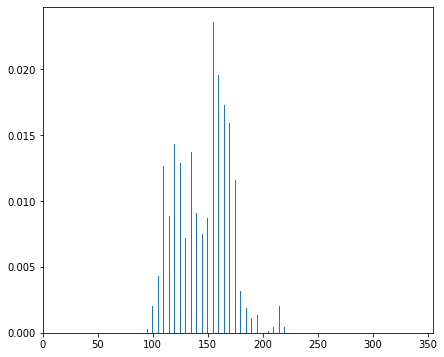

466


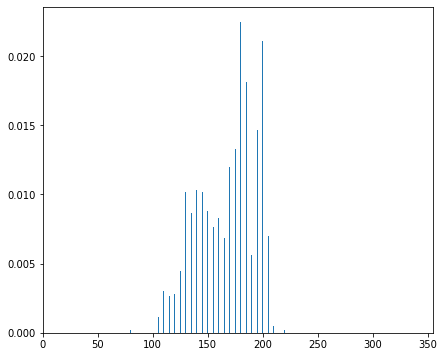

390


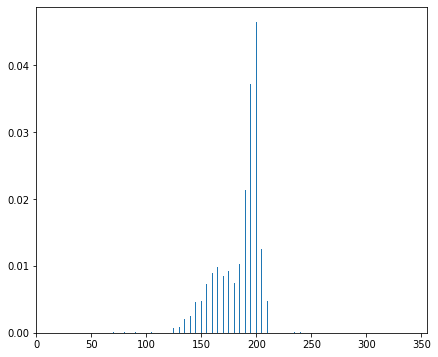

389


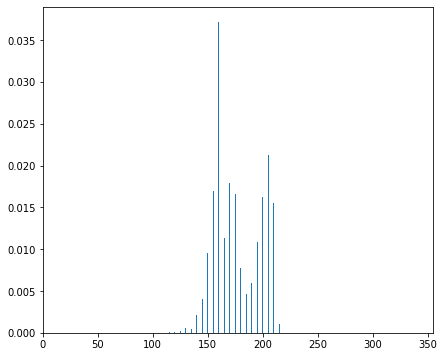

336


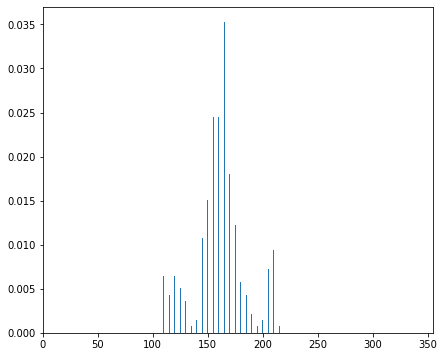

421


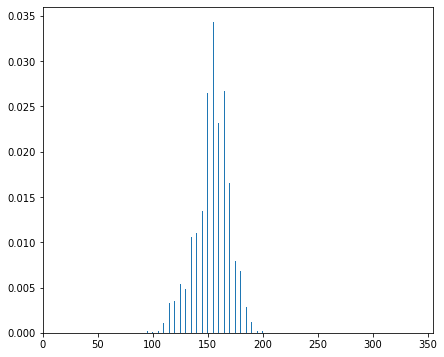

E49


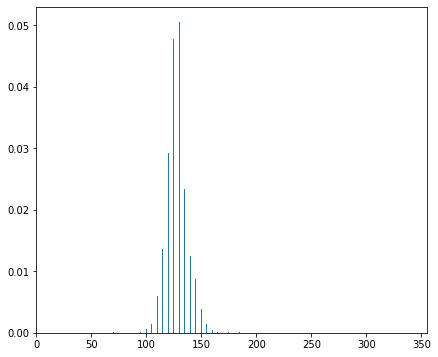

NP1562Dfdb


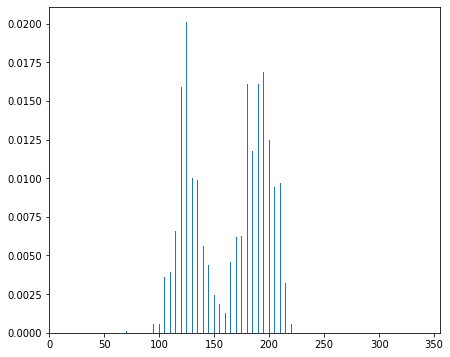

NP1562Cxb


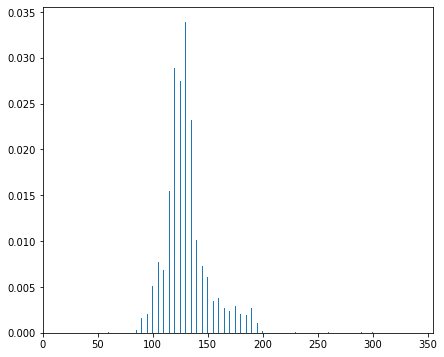

308


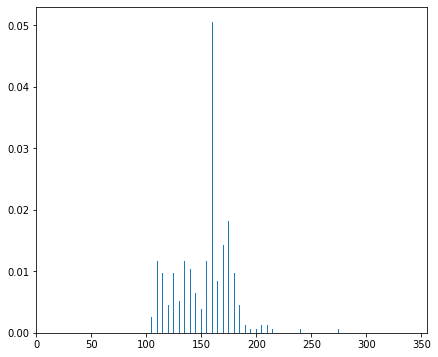

Gr64fa


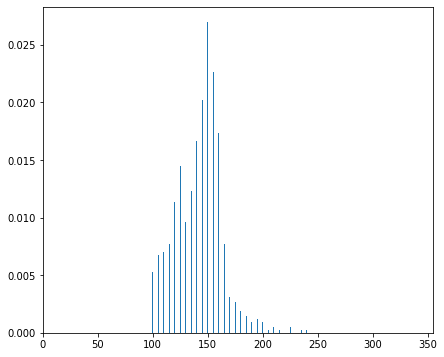

486


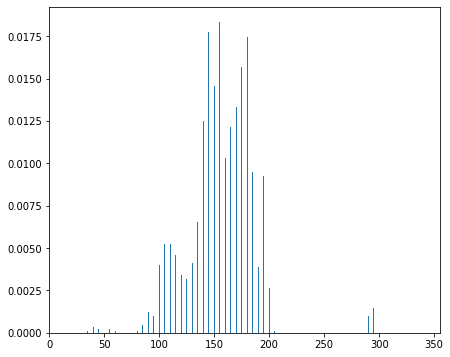

491


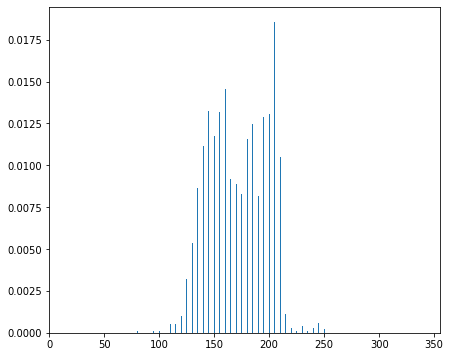

492


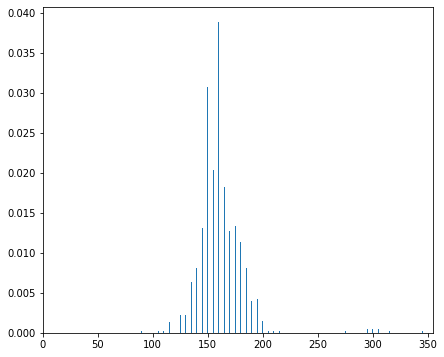

499


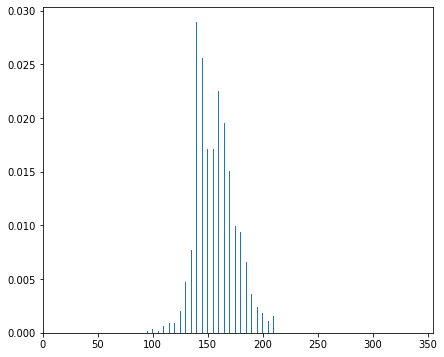

468


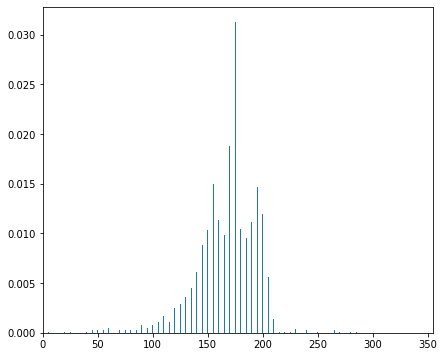

502


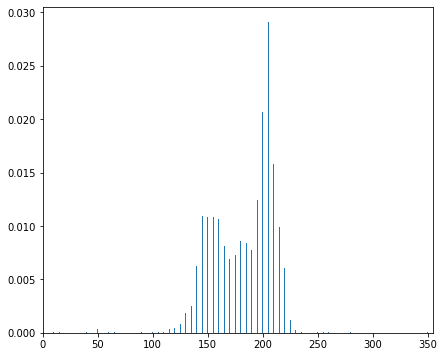

573


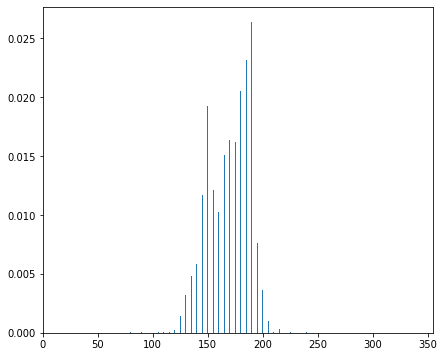

469


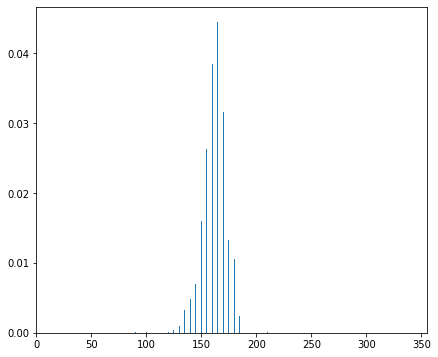

29


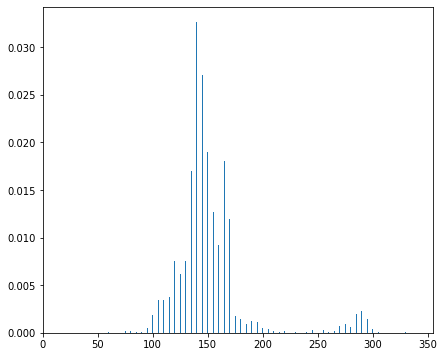

370


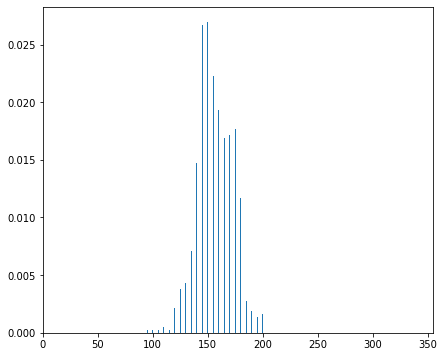

467


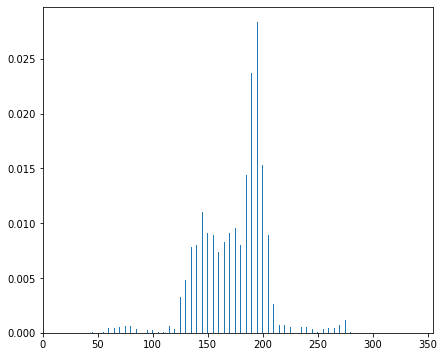

494


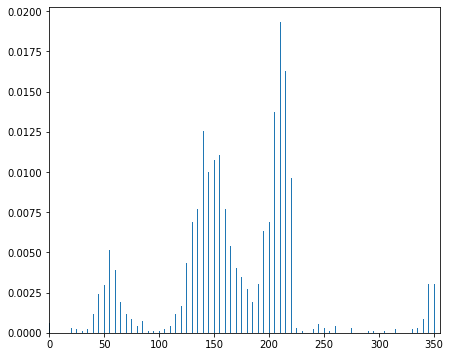

306


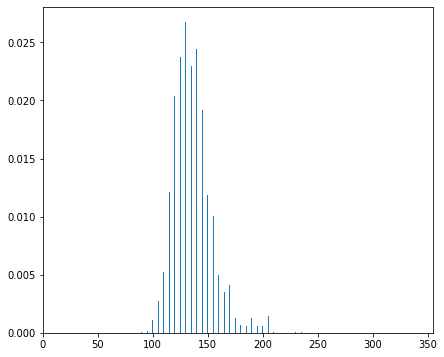

202


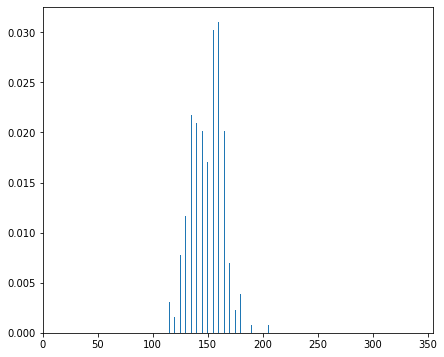

201


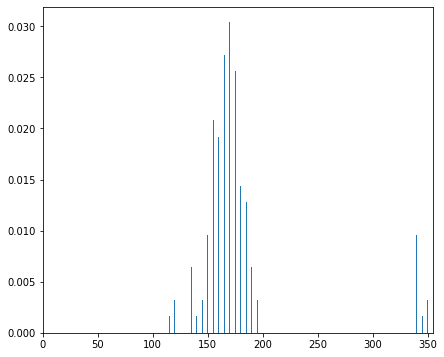

320


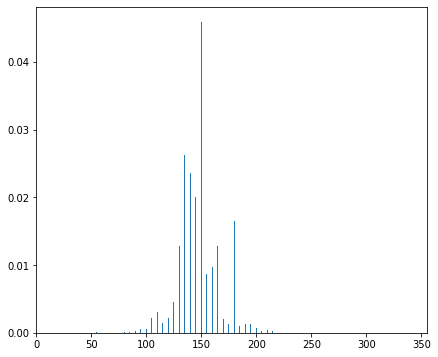

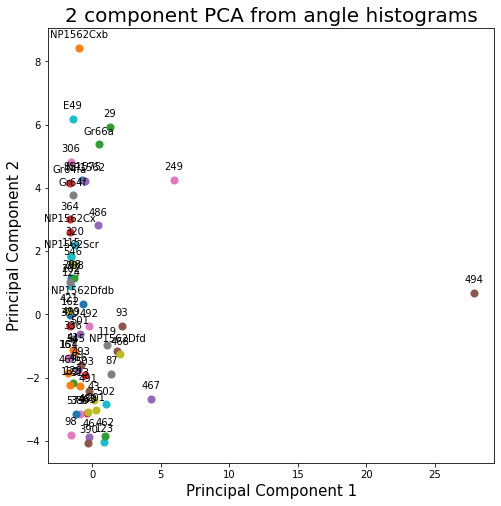

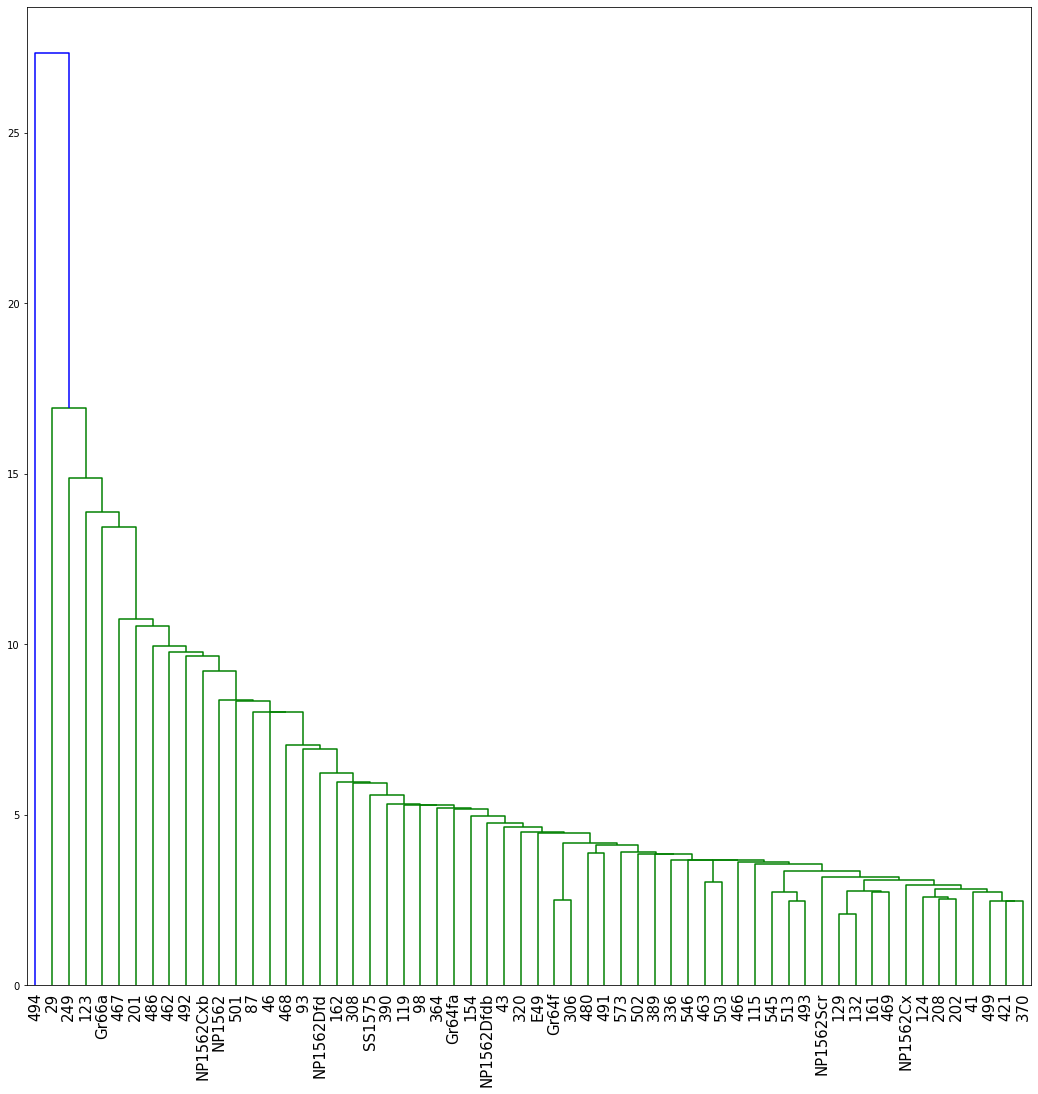

In [ ]:
#The following code makes histogram frequency plots of the angles the proboscis extends when it moves past a distance threshold from the head.
#A PCA plot and dendrogram is also made of the angle values

%matplotlib inline
#I want to just get values of distances > some threshold.  This is so that we only analyze angles when the proboscis is at least slightly extended.
THRESHOLD_DISTANCE = 72
thresholded_aggregate_distances=[ [] for neuron in list_of_neurons]
thresholded_aggregate_angles=[ [] for neuron in list_of_neurons]

for neuron_number in range(len(list_of_neurons)):
    for angle, dist in zip(aggregate_angles[neuron_number], aggregate_distances[neuron_number]):
        if dist > (THRESHOLD_DISTANCE / np.mean(np.asarray(agg_eye_to_eye[neuron_number][0]))):
            thresholded_aggregate_angles[neuron_number].append(angle)
            thresholded_aggregate_distances[neuron_number].append(dist)

hist_values_angles  =[ [] for _ in range(len(thresholded_aggregate_angles))]
for i in range(len(thresholded_aggregate_angles)):
    hist_values_to_add, bin_edges =np.histogram(thresholded_aggregate_angles[i], bins = range(0, 360, 5), density = True) #density means not counts
    hist_values_angles[i]= hist_values_to_add
    # The following is for diagnostic reasons, to see what these distributions look like
    print(list_of_neurons[i])
    plt.figure(figsize=(7,6))
    plt.bar(bin_edges[:-1], hist_values_to_add, width = 1)
    plt.xlim(min(bin_edges), max(bin_edges))
    plt.show() 

# Now show the summary plots for angles!

# StandardScaler scales all of our vectors.
hist_values_angles_scaled = StandardScaler().fit_transform(hist_values_angles)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(hist_values_angles_scaled)


#Make a dataframe with principle component values
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA from angle histograms', fontsize = 20)
for i in range(len(list_of_neurons)):
        ax.scatter(principalDf.loc[i, 'principal component 1']
               , principalDf.loc[i, 'principal component 2']
               , 
                s = 50,)
        ax.annotate(list_of_neurons[i], # this is the text
                 (principalDf.loc[i, 'principal component 1'], principalDf.loc[i, 'principal component 2']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
plt.show()

# Make also a dendrogram of the angle values.
linked = linkage(hist_values_angles_scaled, 'single')

fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(1, 1, 1)
dendrogram(linked,
            orientation='top',
            labels=list_of_neurons,
            distance_sort='descending',
            show_leaf_counts=True, )
ax.tick_params(axis='x', which='major', labelsize=15)
plt.show()


In [ ]:
#Develop Confidence Interval plots for the mean duration, distance, and angle of fly proboscis extension
EXTENSION_LIMIT = 2

#Calculate the average extension duration time for each fly taped per neuron
agg_ext_per_fly = [[] for neuron in list_of_neurons]
mean_ext_per_fly = [[] for neuron in list_of_neurons]
freq_ext_per_fly = [[] for neuron in list_of_neurons]
count_per_fly = [[] for neuron in list_of_neurons]
extended_neurons = []
one_frame_tally = 0
two_frame_tally = 0
total_frame_tally = 0

for neuron_number in range(len(list_of_neurons)):
  #We calculate here the number of frames in which the proboscis is extended, i.e., the distance exceeds the threshold distance.
  for i in range(len(agg_dist_per_fly[neuron_number])):
    threshold_dist = THRESHOLD_DISTANCE / agg_eye_to_eye[neuron_number][0][i]
    agg_frames = []
    frames = 0
    for dist in agg_dist_per_fly[neuron_number][i]:
      if (frames >= 1 and dist > threshold_dist):
        frames += 1
      elif (frames == 0 and dist > threshold_dist):
        frames = 1
      elif (frames >= 1 and dist < threshold_dist):
        if (frames <= EXTENSION_LIMIT):
          frames = 0
        else:
          total_frame_tally += 1
          frames = frames/neuron_vid_data[list_of_neurons[neuron_number]]["frame_rate"]
          agg_frames.append(frames)
          frames = 0
      else:
        continue
    
    if (frames > EXTENSION_LIMIT):
        frames = frames/neuron_vid_data[list_of_neurons[neuron_number]]["frame_rate"]
        agg_frames.append(frames)
    agg_ext_per_fly[neuron_number].append(agg_frames)
    #avg = 0
    if (len(agg_frames) > 0):
      avg = sum(agg_frames)/len(agg_frames)
      mean_ext_per_fly[neuron_number].append(avg)
      freq_ext_per_fly[neuron_number].append(len(agg_frames))
      count_per_fly[neuron_number].append(len(agg_frames))
    if (len(agg_frames) == 0):
      count_per_fly[neuron_number].append(0)
    if (i==7):
      print(agg_frames)
  if (neuron_number == 30):
    print('==================================================================')
  if (len(mean_ext_per_fly[neuron_number]) == 0):
    freq_ext_per_fly[neuron_number].append(0)
  else:
    extended_neurons.append(list_of_neurons[neuron_number])
  
  
#Aggregate the thresholded extension distances and angles for each fly taped per neuron
thresholded_agg_dist_per_fly=[ [] for neuron in list_of_neurons]
thresholded_agg_ang_per_fly=[ [] for neuron in list_of_neurons]

mean_thresh_agg_dist_per_fly = [ [] for neuron in list_of_neurons]
mean_thresh_agg_ang_per_fly = [ [] for neuron in list_of_neurons]

thresholded_agg_etm_per_fly=[ [] for neuron in list_of_neurons]
thresholded_agg_mtl_per_fly=[ [] for neuron in list_of_neurons]

mean_thresh_agg_etm_per_fly = [ [] for neuron in list_of_neurons]
mean_thresh_agg_mtl_per_fly = [ [] for neuron in list_of_neurons]

for neuron_number in range(len(list_of_neurons)):
  for fly in range(len(agg_dist_per_fly[neuron_number])):
    threshold_dist = THRESHOLD_DISTANCE / agg_eye_to_eye[neuron_number][0][fly]
    agg_dist = []
    agg_ang = []
    agg_etm = []
    agg_mtl = []

    agg_frame_dist = []
    agg_frame_ang = []
    agg_frame_etm = []
    agg_frame_mtl = []
    frames = 0
    for angle, dist, etm, mtl in zip(agg_ang_per_fly[neuron_number][fly],agg_dist_per_fly[neuron_number][fly], agg_eye_to_maxpalp_per_fly[neuron_number][fly], agg_maxpalp_to_labellum_per_fly[neuron_number][fly]):
      if (dist > threshold_dist):
        frames += 1
        agg_frame_dist.append(dist)
        agg_frame_ang.append(angle)
        agg_frame_etm.append(etm)
        agg_frame_mtl.append(mtl)
      elif (frames >= 1 and dist < threshold_dist):
        if (frames <= EXTENSION_LIMIT):
          frames = 0
          agg_frame_dist = []
          agg_frame_ang = []
          agg_frame_etm = []
          agg_frame_mtl = []
        else:
          agg_etm.extend(agg_frame_etm)
          agg_mtl.extend(agg_frame_mtl)
          agg_ang.extend(agg_frame_ang)
          agg_dist.extend(agg_frame_dist)
          frames = 0
      else:
        continue
    if (frames > EXTENSION_LIMIT):
        agg_etm.extend(agg_frame_etm)
        agg_mtl.extend(agg_frame_mtl)
        agg_ang.extend(agg_frame_ang)
        agg_dist.extend(agg_frame_dist)           
    if (len(agg_ang) != 0) & (len(agg_dist) != 0):
      mean_thresh_agg_dist_per_fly[neuron_number].append(np.mean(agg_dist)) 
      mean_thresh_agg_ang_per_fly[neuron_number].append(np.mean(agg_ang))
      mean_thresh_agg_etm_per_fly[neuron_number].append(np.mean(agg_etm))
      mean_thresh_agg_mtl_per_fly[neuron_number].append(np.mean(agg_mtl))
      thresholded_agg_etm_per_fly[neuron_number].append(agg_etm)
      thresholded_agg_mtl_per_fly[neuron_number].append(agg_mtl)
      thresholded_agg_dist_per_fly[neuron_number].append(agg_dist)
      thresholded_agg_ang_per_fly[neuron_number].append(agg_ang)

#Max angle and distance
angle_at_max_ext = [ [] for neuron in list_of_neurons]
dist_at_max_ext = [ [] for neuron in list_of_neurons]
etm_at_max_ext = [ [] for neuron in list_of_neurons]
mtl_at_max_ext = [ [] for neuron in list_of_neurons]
max_etm = [ [] for neuron in list_of_neurons]
max_mtl = [ [] for neuron in list_of_neurons]

for neuron_number in range(len(list_of_neurons)):
  for fly in range(len(thresholded_agg_dist_per_fly[neuron_number])):
    dist_at_max = max(thresholded_agg_dist_per_fly[neuron_number][fly])
    dist_at_max_ext[neuron_number].append(dist_at_max)
    max_etm[neuron_number].append(max(thresholded_agg_etm_per_fly[neuron_number][fly]))
    max_mtl[neuron_number].append(max(thresholded_agg_mtl_per_fly[neuron_number][fly]))
    angle_at_max_ext[neuron_number].append(thresholded_agg_ang_per_fly[neuron_number][fly][np.argmax(thresholded_agg_dist_per_fly[neuron_number][fly])])
    etm_at_max_ext[neuron_number].append(thresholded_agg_etm_per_fly[neuron_number][fly][np.argmax(thresholded_agg_dist_per_fly[neuron_number][fly])])
    mtl_at_max_ext[neuron_number].append(thresholded_agg_mtl_per_fly[neuron_number][fly][np.argmax(thresholded_agg_dist_per_fly[neuron_number][fly])])




[4.633333333333334, 6.533333333333333, 2.4]
[5.233333333333333, 0.43333333333333335, 0.5, 0.2, 0.2, 1.1]
[0.1, 0.6, 0.4]
[10.833333333333334]
[4.966666666666667, 8.0]
[2.6333333333333333]
[0.16666666666666666]
[2.1666666666666665]
[7.966666666666667]
[0.16666666666666666, 0.16666666666666666, 0.2, 1.2333333333333334, 0.16666666666666666, 0.1]
[]
[]
[0.6, 0.13333333333333333, 0.16666666666666666, 0.43333333333333335, 0.13333333333333333, 0.1]
[5.966666666666667]
[0.1, 1.1333333333333333]
[9.166666666666666, 1.5666666666666667]
[]
[8.4, 0.3, 0.26666666666666666, 3.3]
[0.1, 5.066666666666666, 0.1, 3.466666666666667]
[]
[0.6333333333333333, 1.4333333333333333, 0.1, 0.23333333333333334, 0.4, 2.2]
[1.3, 7.9, 0.43333333333333335, 0.26666666666666666, 0.7666666666666667, 0.3333333333333333]
[3.1, 8.5]
[]
[0.23333333333333334, 0.1, 0.13333333333333333, 0.1, 0.6, 0.3, 0.4, 2.6333333333333333, 0.5, 0.3333333333333333, 0.9333333333333333, 2.1666666666666665, 2.2]
[1.9333333333333333, 13.0]
[0.4333

Plot the median duration, distance, and angle the proboscis makes when extended.

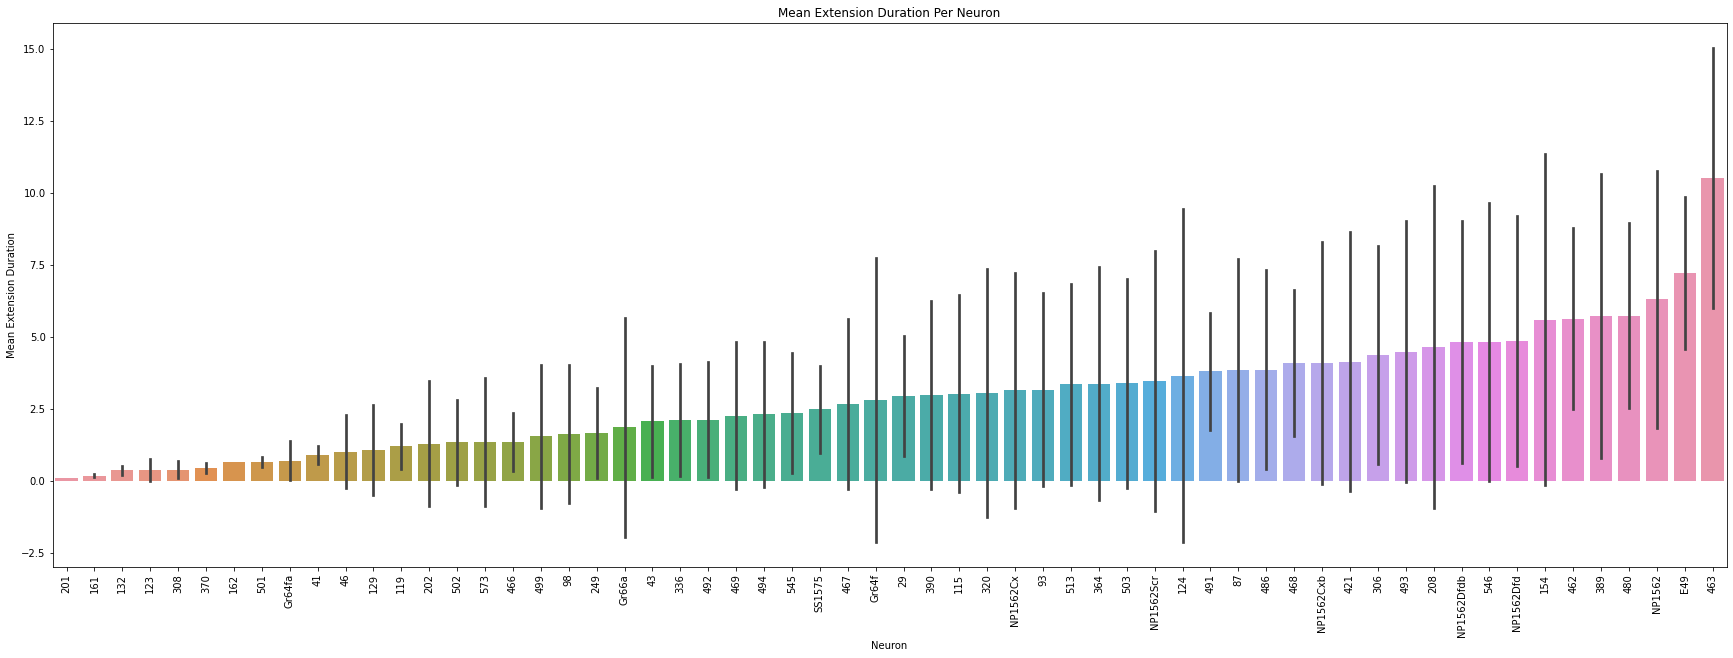

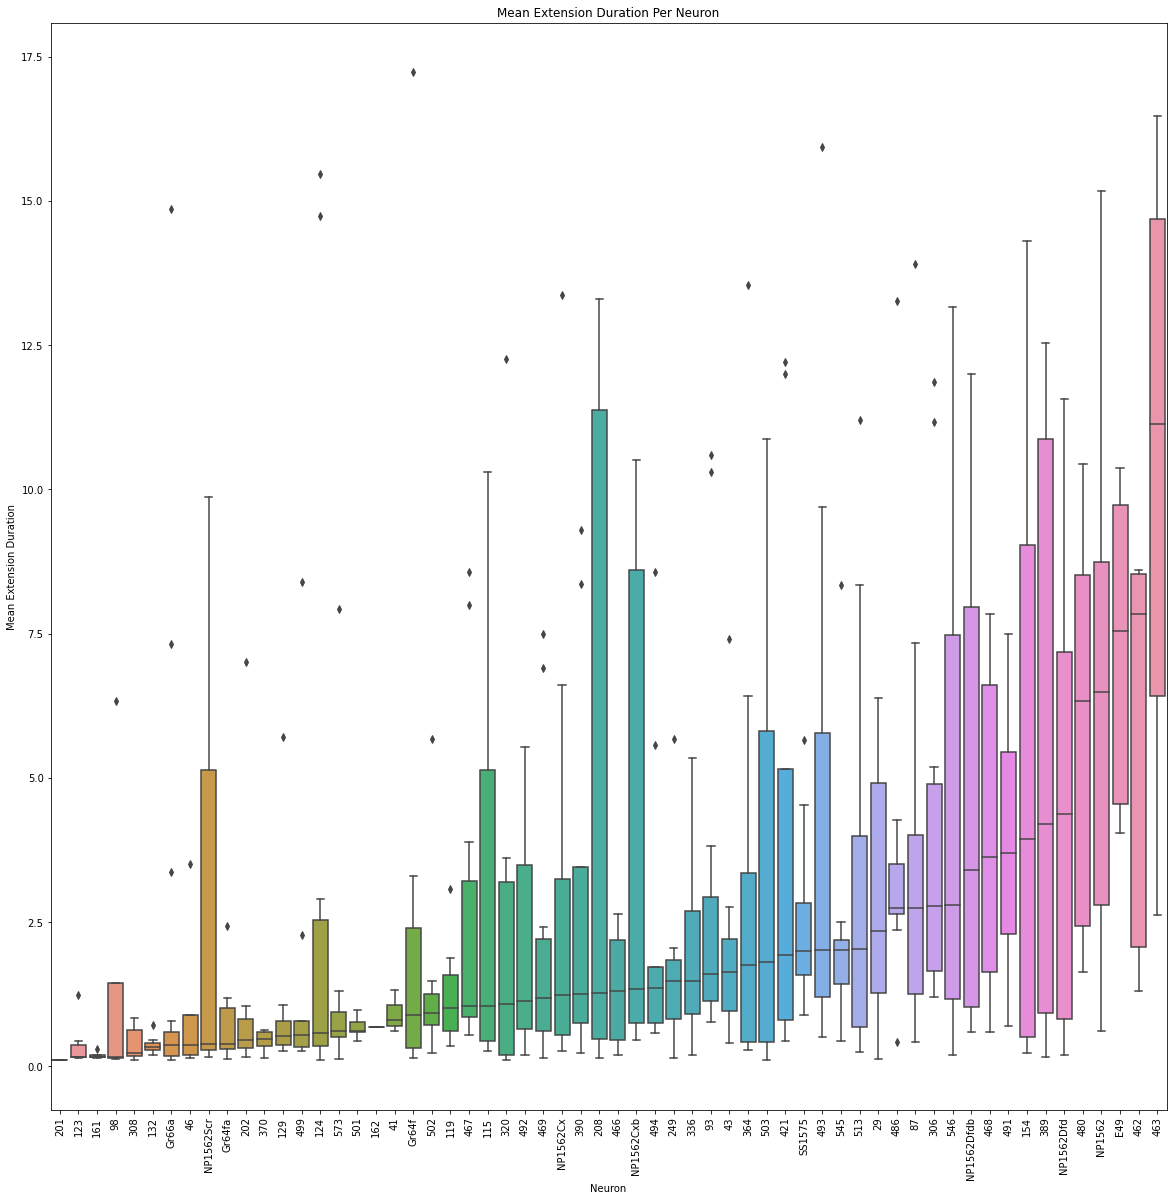

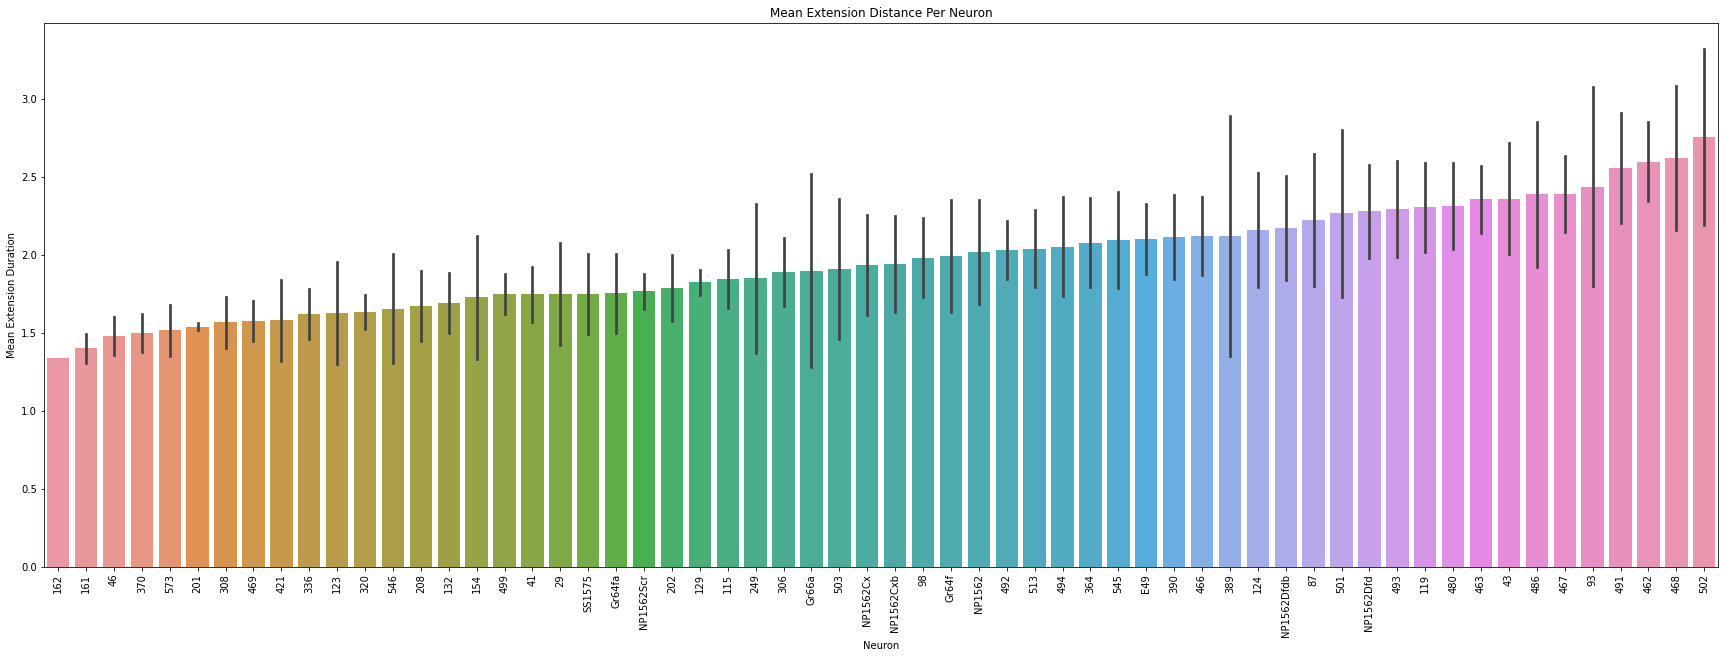

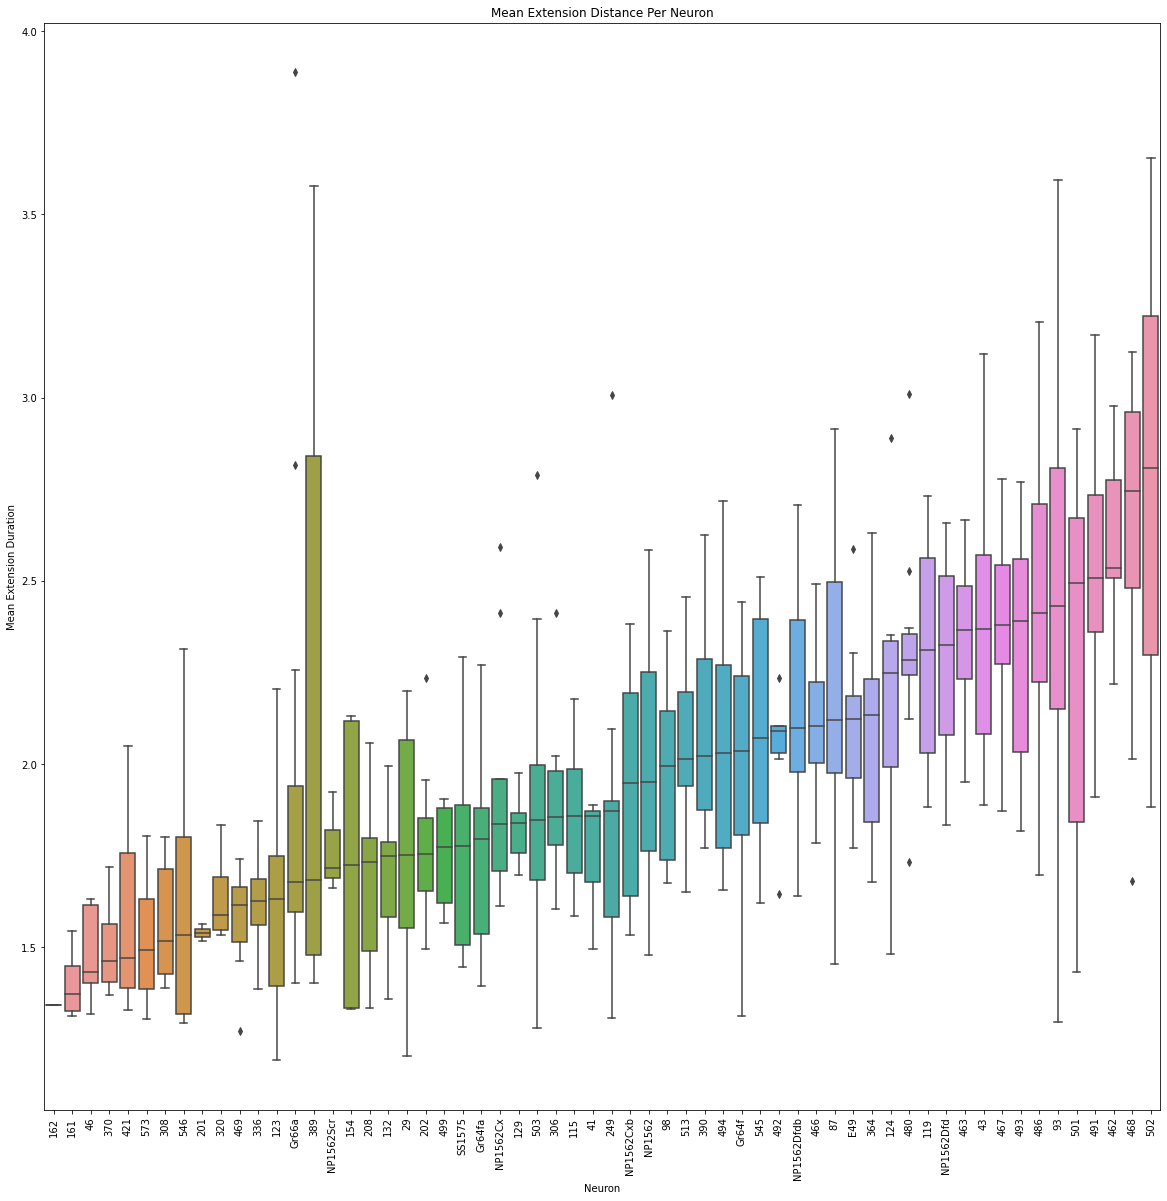

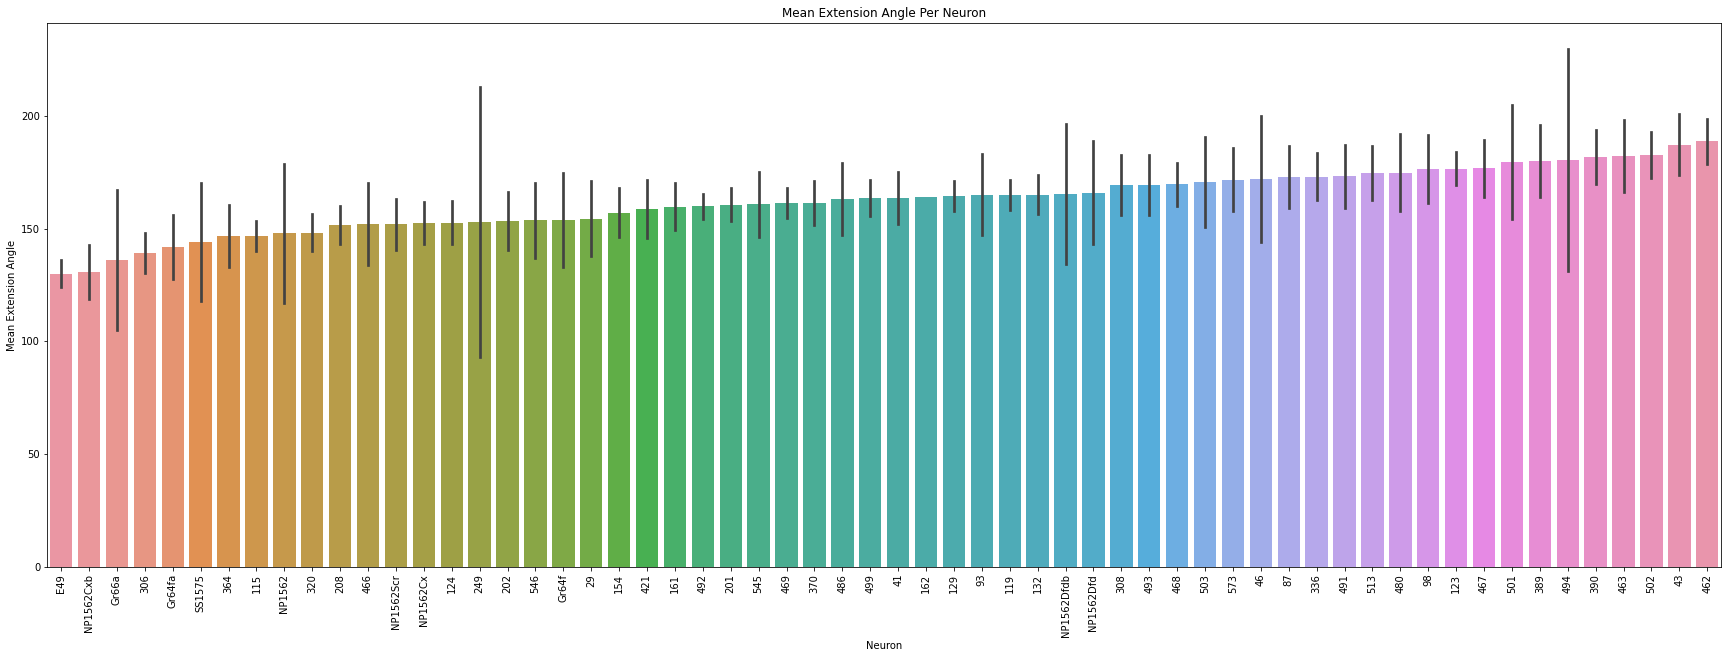

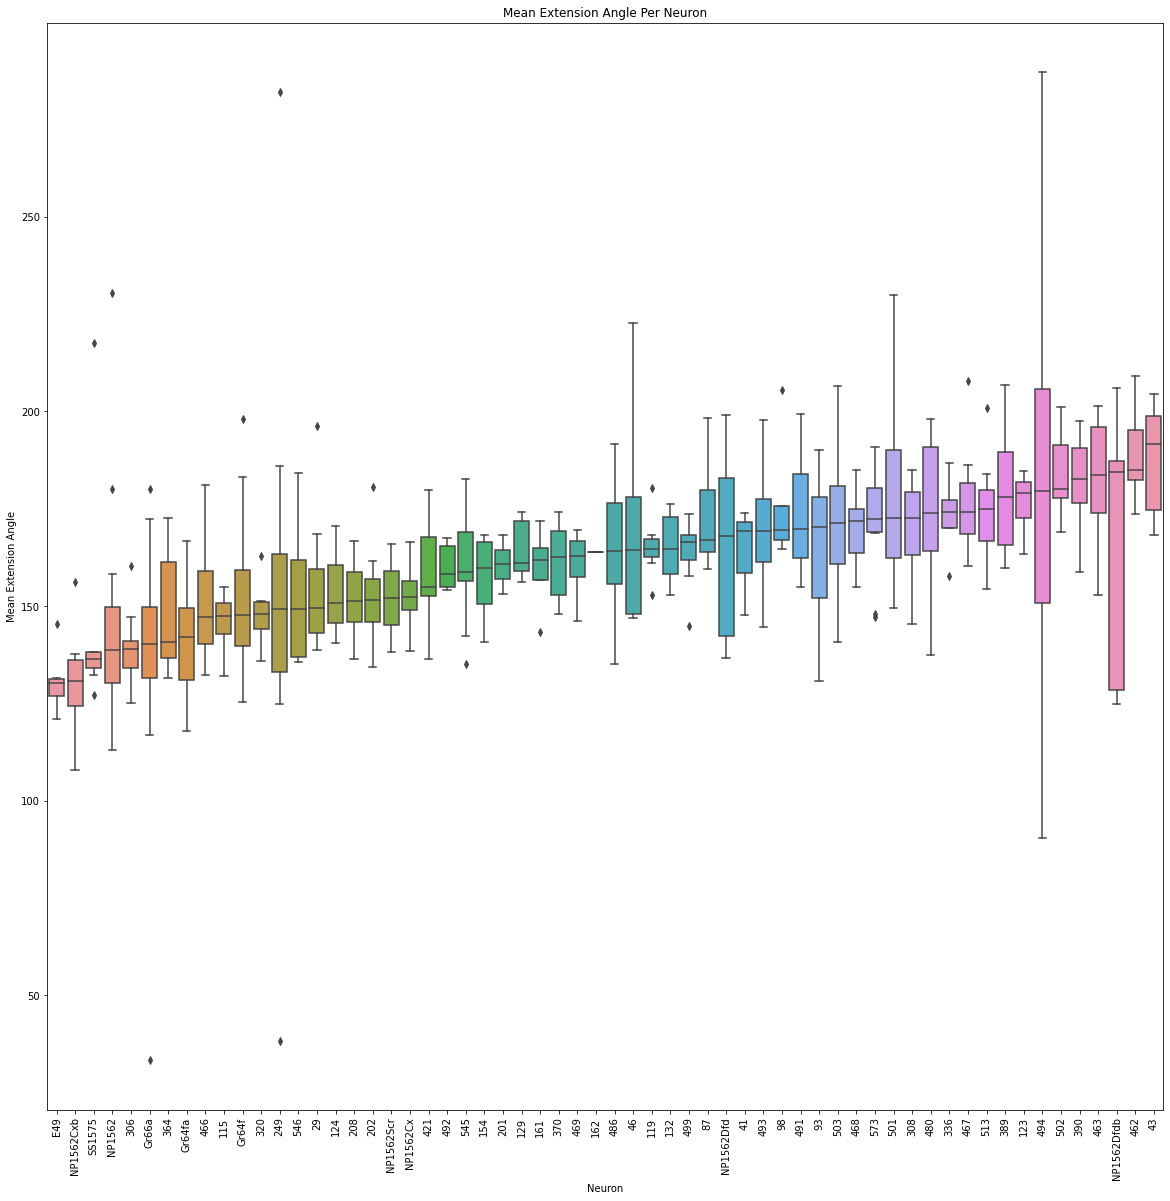

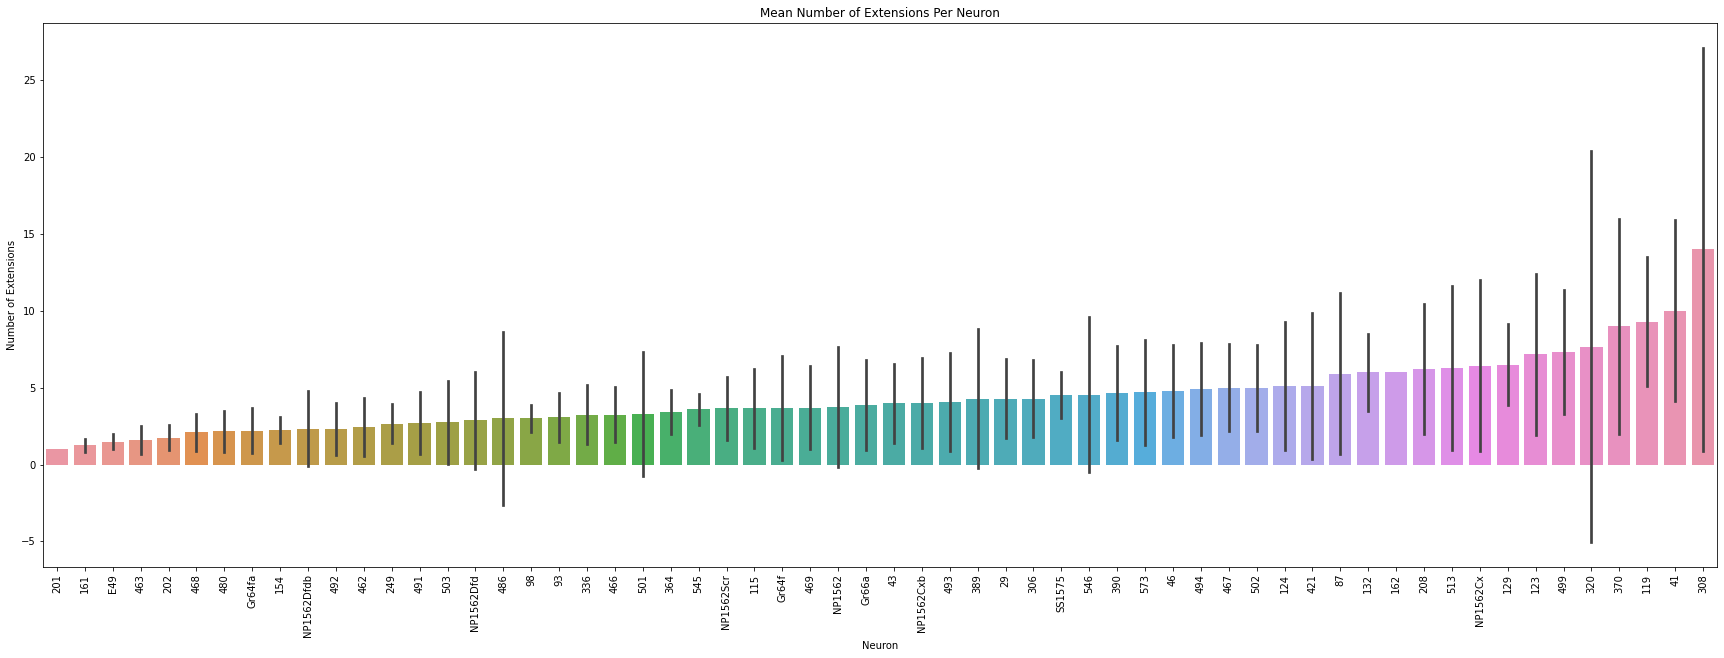

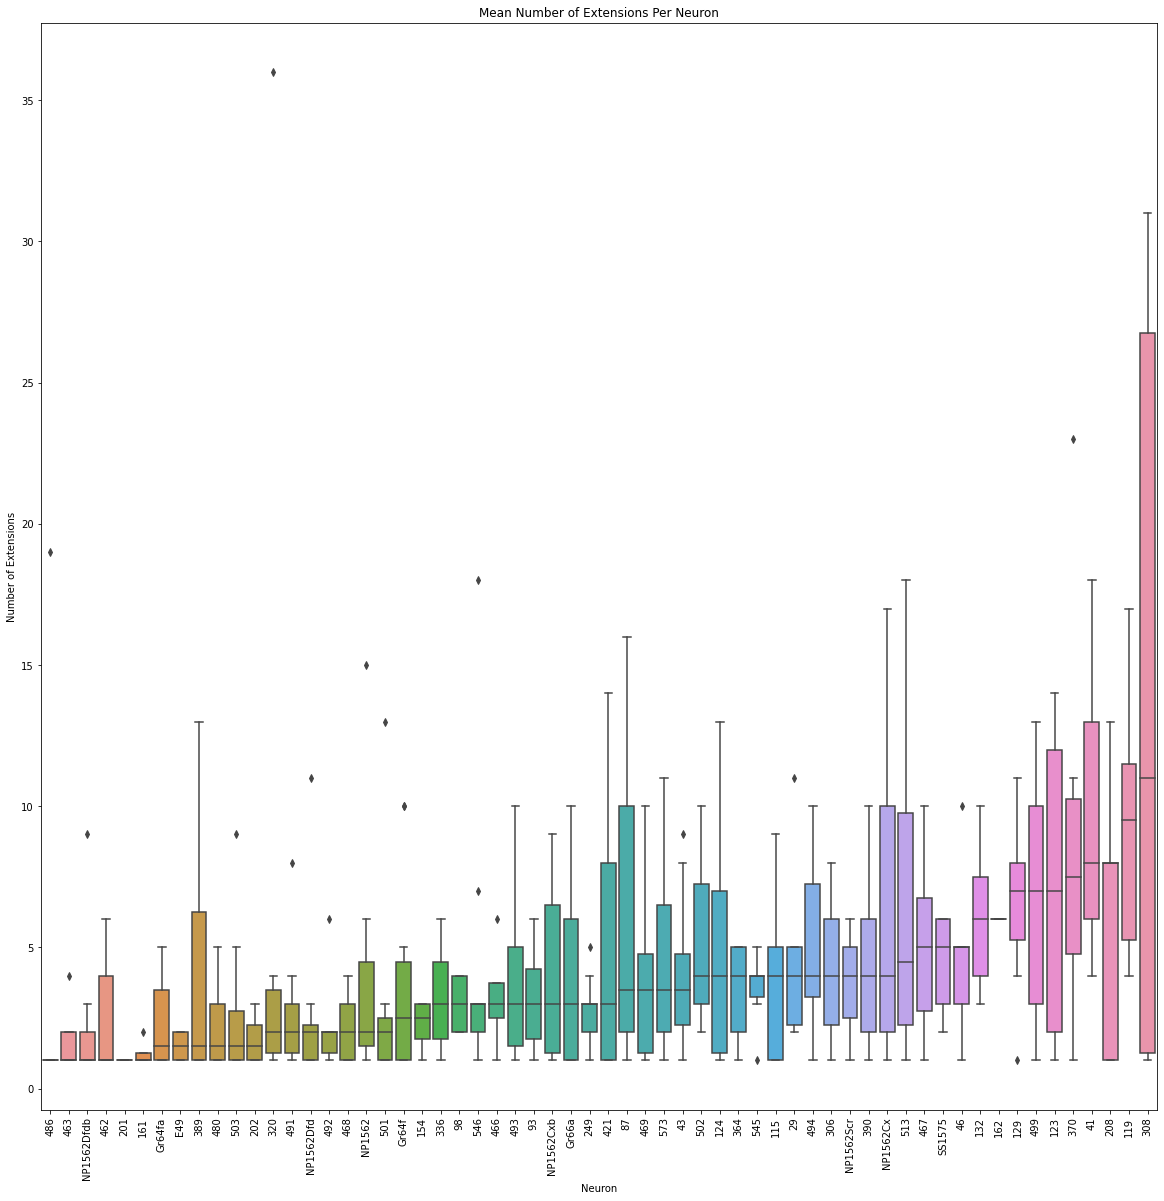

In [ ]:
%matplotlib inline
build_std_dev_barplot(mean_ext_per_fly, "Mean Extension Duration", "Mean Extension Duration Per Neuron", extended_neurons)
build_std_dev_barplot(mean_thresh_agg_dist_per_fly, "Mean Extension Duration", "Mean Extension Distance Per Neuron", list_of_neurons)
build_std_dev_barplot(mean_thresh_agg_ang_per_fly, "Mean Extension Angle", "Mean Extension Angle Per Neuron", list_of_neurons)
build_std_dev_barplot(freq_ext_per_fly, "Number of Extensions", "Mean Number of Extensions Per Neuron", list_of_neurons)


Z-score each of the values so each set of values can be more easily compared.

In [ ]:
mean_ext_per_neuron = [np.mean(neuron) for neuron in mean_ext_per_fly]
mean_thresh_agg_dist_per_neuron = [np.mean(neuron) for neuron in mean_thresh_agg_dist_per_fly]
mean_thresh_agg_ang_per_neuron = [np.mean(neuron) for neuron in mean_thresh_agg_ang_per_fly]
freq_ext_per_neuron = [np.mean(neuron) for neuron in freq_ext_per_fly]
mean_angle_at_max_ext = [np.mean(neuron) for neuron in angle_at_max_ext]
mean_dist_at_max_ext = [np.mean(neuron) for neuron in dist_at_max_ext]
mean_etm_at_max_ext = [np.mean(neuron) for neuron in etm_at_max_ext]
mean_mtl_at_max_ext = [np.mean(neuron) for neuron in mtl_at_max_ext]
mean_thresh_agg_etm_per_neuron = [np.mean(neuron) for neuron in mean_thresh_agg_etm_per_fly]
mean_thresh_agg_mtl_per_neuron = [np.mean(neuron) for neuron in mean_thresh_agg_mtl_per_fly]
mean_max_etm = [np.mean(neuron) for neuron in max_etm]
mean_max_mtl = [np.mean(neuron) for neuron in max_mtl]

processed_data = pd.DataFrame({'Mean Ext.': mean_ext_per_neuron, 'Mean Thresholded Ext. Distance': mean_thresh_agg_dist_per_neuron, 'Mean Thresholded Angle': mean_thresh_agg_ang_per_neuron, 
                               'Mean Ext. Frequency': freq_ext_per_neuron, 'Mean Angle at Max Ext.': mean_angle_at_max_ext, 'Mean Distance at Max Ext.': mean_dist_at_max_ext, 
                               'Mean ETM Length at Max Ext.': mean_etm_at_max_ext, 'Mean MTL Length at Max Ext.': mean_mtl_at_max_ext,'Mean Thresholded ETM Length': mean_thresh_agg_etm_per_neuron, 
                               'Mean Thresholded MTL Length': mean_thresh_agg_mtl_per_neuron, 'Mean Max ETM Length': mean_max_etm, 'Mean Max MTL Length': mean_max_mtl}, index=list_of_neurons)

In [ ]:
processed_data.columns

Index(['Mean Ext.', 'Mean Thresholded Ext. Distance', 'Mean Thresholded Angle',
       'Mean Ext. Frequency', 'Mean Angle at Max Ext.',
       'Mean Distance at Max Ext.', 'Mean ETM Length at Max Ext.',
       'Mean MTL Length at Max Ext.', 'Mean Thresholded ETM Length',
       'Mean Thresholded MTL Length', 'Mean Max ETM Length',
       'Mean Max MTL Length'],
      dtype='object')

In [ ]:
processed_data

,Mean Ext.,Mean Thresholded Ext. Distance,Mean Thresholded Angle,Mean Ext. Frequency,Mean Angle at Max Ext.,Mean Distance at Max Ext.,Mean ETM Length at Max Ext.,Mean MTL Length at Max Ext.,Mean Thresholded ETM Length,Mean Thresholded MTL Length,Mean Max ETM Length,Mean Max MTL Length
SS1575,2.497099,1.750044,144.153113,4.555556,144.461568,2.305935,1.315939,1.128733,0.862362,0.889283,1.341363,1.324101
513,3.357645,2.039485,174.648898,6.300000,201.361463,2.684206,1.325230,1.421896,0.925164,1.118960,1.394957,1.579904
Gr66a,1.862512,1.899114,136.094854,3.875000,129.246675,2.357634,1.148935,1.311551,0.956482,0.950769,1.350348,1.538544
463,10.515000,2.355481,182.285971,1.600000,200.793832,2.816925,1.570254,1.321960,1.228102,1.178966,1.598749,1.566764
NP1562,6.312424,2.017939,147.895675,3.727273,168.024563,2.854888,1.648310,1.309957,1.171040,1.001664,1.699632,1.521791
93,3.177037,2.437306,165.066506,3.083333,181.652074,3.182825,1.822229,1.426971,1.282745,1.252867,1.911483,1.750276
249,1.670679,1.848719,152.956661,2.666667,152.394588,2.414106,1.674930,1.339823,1.206462,1.212833,1.855360,1.747047
Gr64f,2.813667,1.992612,153.853756,3.700000,174.305079,2.633475,1.335341,1.180490,0.936596,1.023910,1.387019,1.544945
480,5.736435,2.312820,174.835015,2.166667,192.565933,2.882609,1.413793,1.538806,1.148962,1.193931,1.564698,1.647328
124,3.659517,2.160008,152.671445,5.100000,172.240979,2.847221,1.575388,1.248284,1.235543,1.031520,1.670784,1.351498


In [ ]:
z_scores = pd.DataFrame()
processed_data
cols = list(processed_data.columns)

for col in cols:
    col_zscore = col + '_zscore'
    z_scores[col_zscore] = (processed_data[col] - processed_data[col].mean())/processed_data[col].std(ddof=0)
z_scores

,Mean Ext._zscore,Mean Thresholded Ext. Distance_zscore,Mean Thresholded Angle_zscore,Mean Ext. Frequency_zscore,Mean Angle at Max Ext._zscore,Mean Distance at Max Ext._zscore,Mean ETM Length at Max Ext._zscore,Mean MTL Length at Max Ext._zscore,Mean Thresholded ETM Length_zscore,Mean Thresholded MTL Length_zscore,Mean Max ETM Length_zscore,Mean Max MTL Length_zscore
SS1575,-0.218505,-0.643352,-1.353803,0.071415,-1.463688,-0.458935,-0.260903,-0.232539,-1.118310,-0.468520,-0.477544,-0.227456
513,0.216746,0.233131,0.892582,0.823364,1.485517,0.309503,-0.228711,1.042078,-0.790231,0.888605,-0.303678,0.631226
Gr66a,-0.539469,-0.191940,-1.947391,-0.221941,-2.252298,-0.353911,-0.839578,0.562319,-0.626629,-0.105208,-0.448396,0.492389
463,3.836823,1.190031,1.455145,-1.202588,1.456096,0.579115,0.620303,0.607574,0.792314,1.243174,0.357443,0.587118
NP1562,1.711227,0.167888,-1.078118,-0.285619,-0.242383,0.656235,0.890766,0.555391,0.494223,0.195524,0.684719,0.436151
93,0.125397,1.437812,0.186722,-0.563192,0.463951,1.322424,1.493398,1.064145,1.077767,1.679844,1.371988,1.203134
249,-0.636495,-0.344545,-0.705315,-0.742797,-1.052508,-0.239192,0.983007,0.685241,0.679267,1.443290,1.189919,1.192294
Gr64f,-0.058390,0.091192,-0.639233,-0.297375,0.083145,0.206447,-0.193676,-0.007510,-0.730514,0.326969,-0.329430,0.513875
480,1.419901,1.060844,0.906291,-0.958324,1.029632,0.712550,0.078161,1.550379,0.378886,1.331599,0.246979,0.857556
124,0.369428,0.598099,-0.726324,0.306100,-0.023840,0.640661,0.638091,0.287247,0.831183,0.371936,0.591134,-0.135490


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


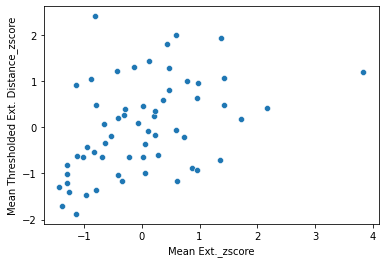

In [ ]:
sns.scatterplot(z_scores['Mean Ext._zscore'], z_scores['Mean Thresholded Ext. Distance_zscore'])

Mean Ext._zscore
Mean Thresholded Ext. Distance_zscore
Mean Thresholded Angle_zscore
Mean Ext. Frequency_zscore
Mean Angle at Max Ext._zscore
Mean Distance at Max Ext._zscore
Mean ETM Length at Max Ext._zscore
Mean MTL Length at Max Ext._zscore
Mean Thresholded ETM Length_zscore
Mean Thresholded MTL Length_zscore
Mean Max ETM Length_zscore
Mean Max MTL Length_zscore


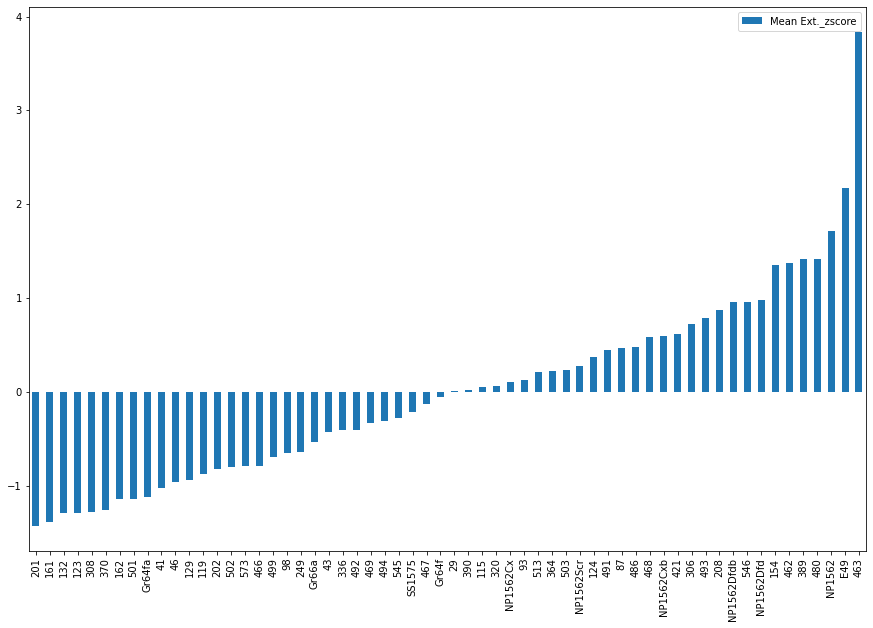

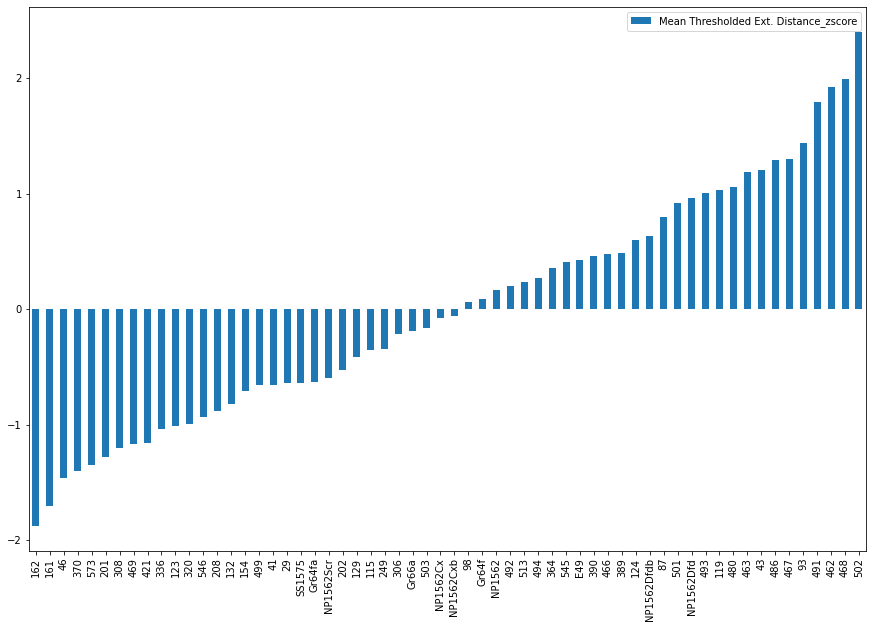

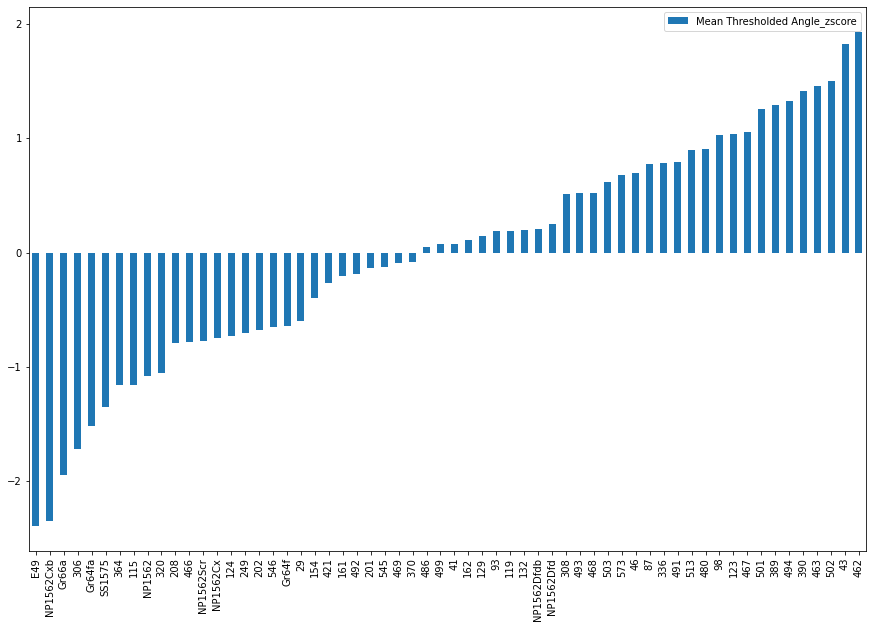

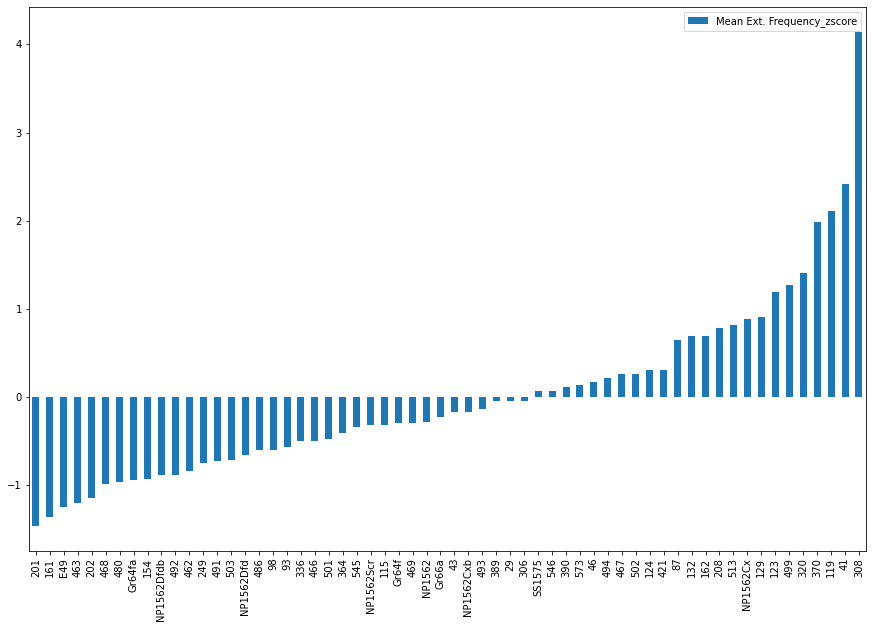

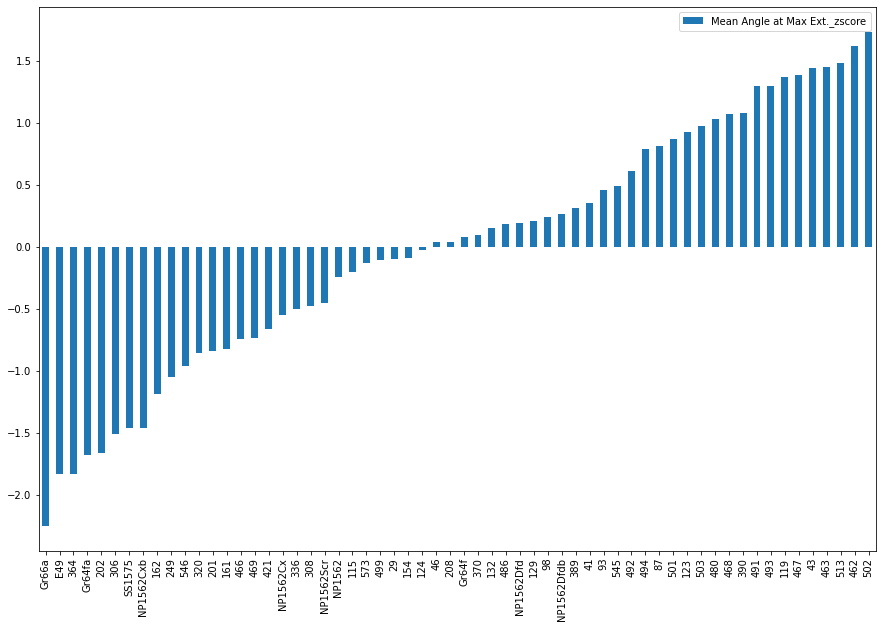

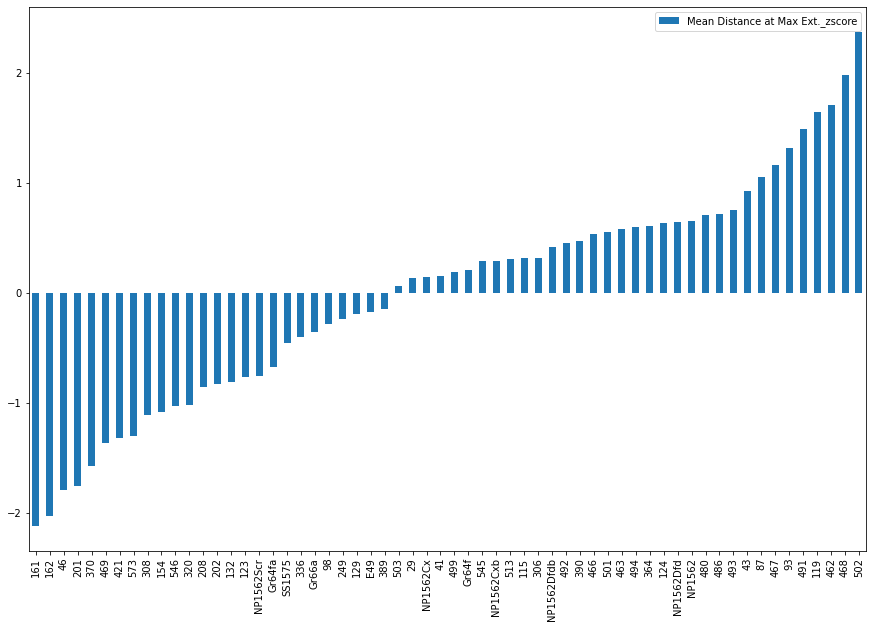

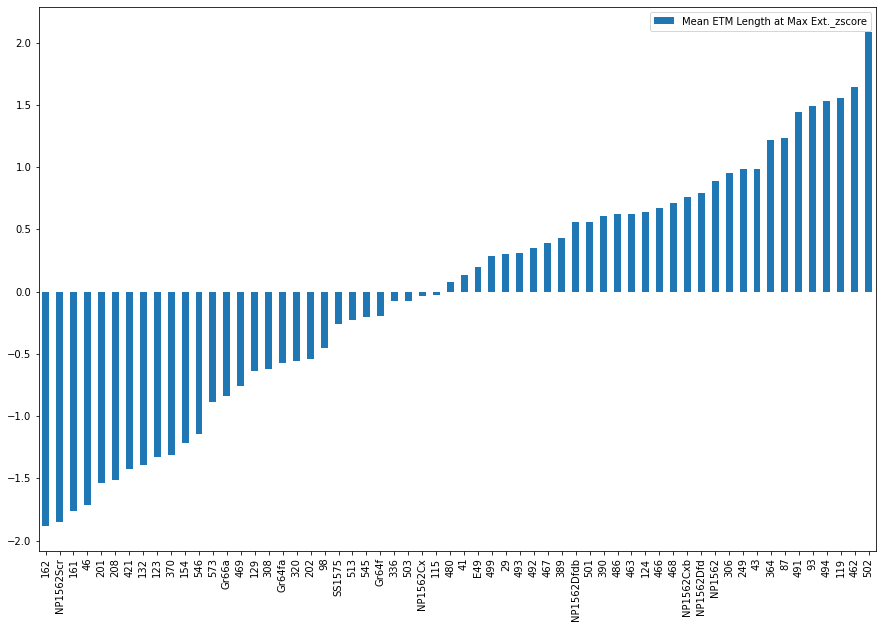

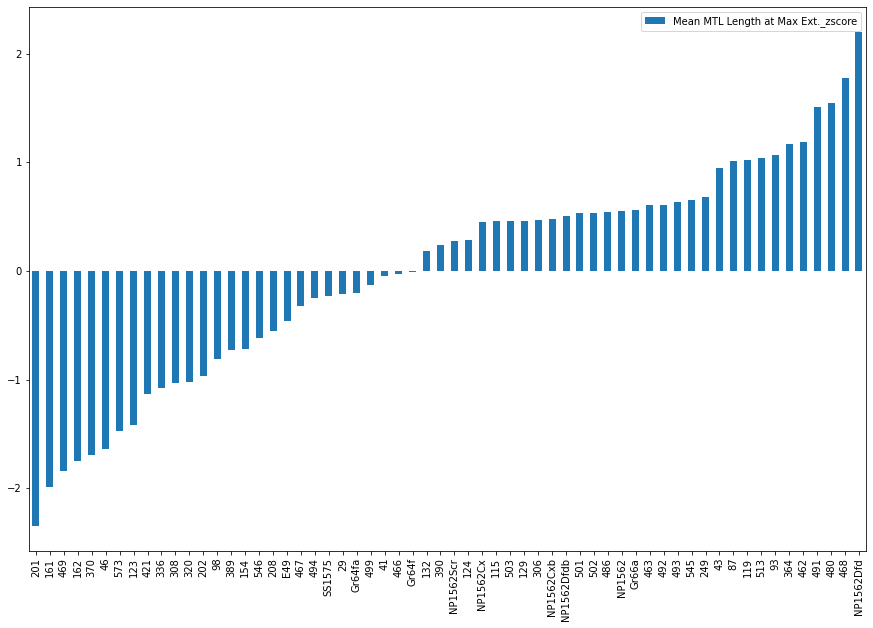

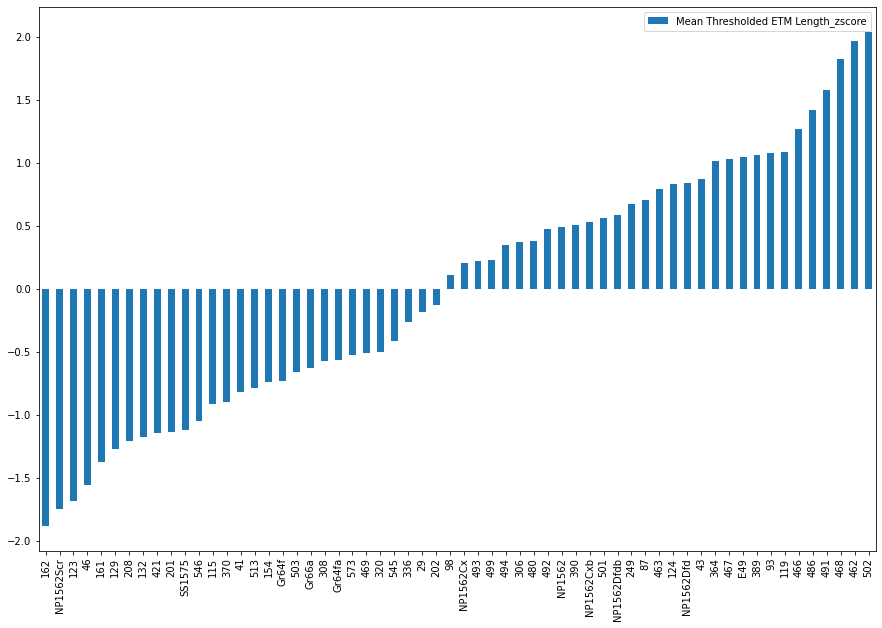

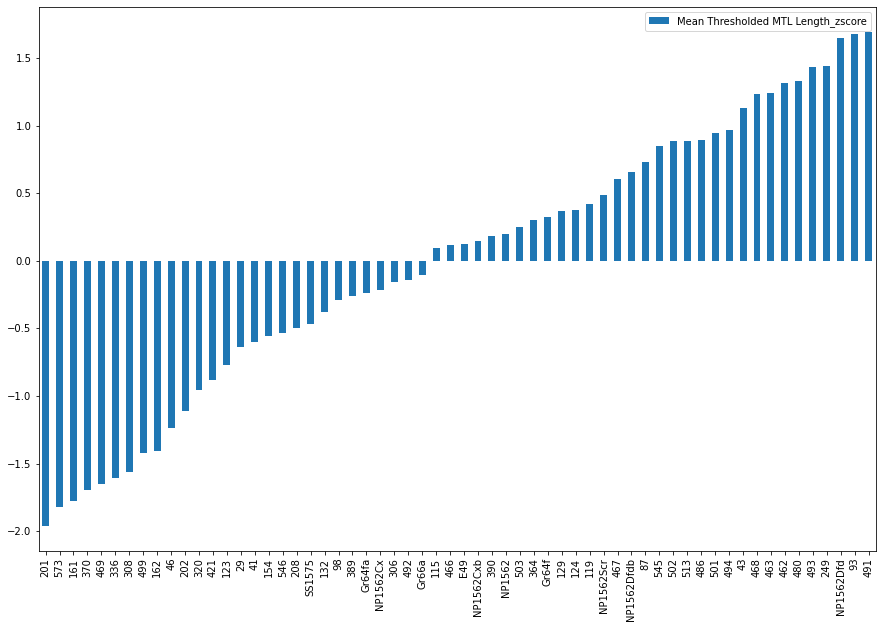

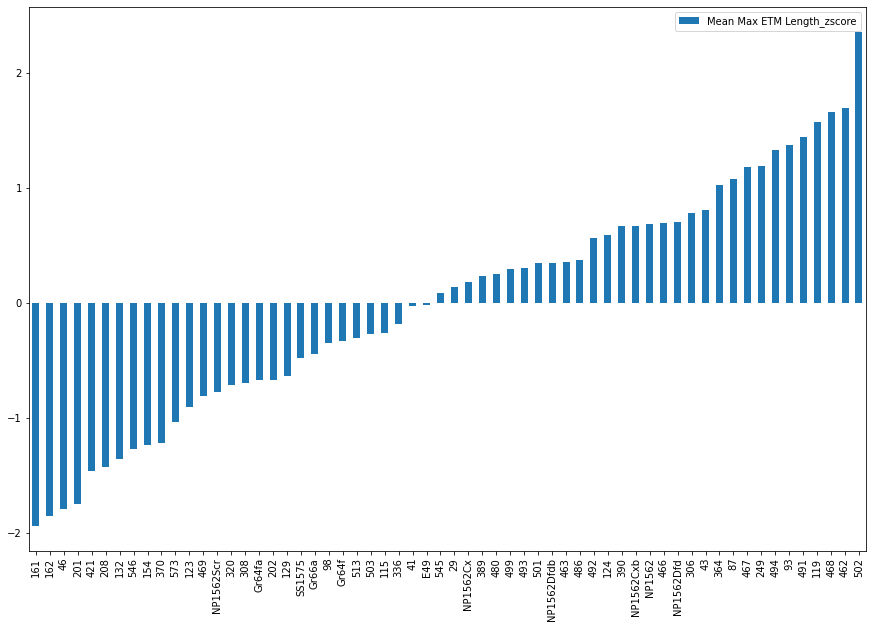

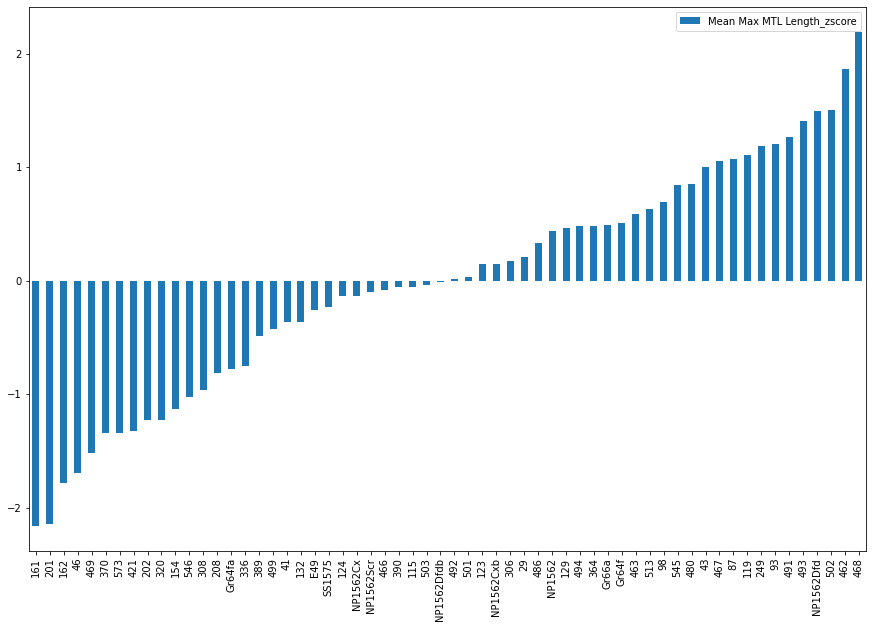

In [ ]:
%matplotlib inline
for column in z_scores.columns:
  print(column)
  z_scores[[column]].sort_values(by=[column]).plot.bar(figsize=(15,10))

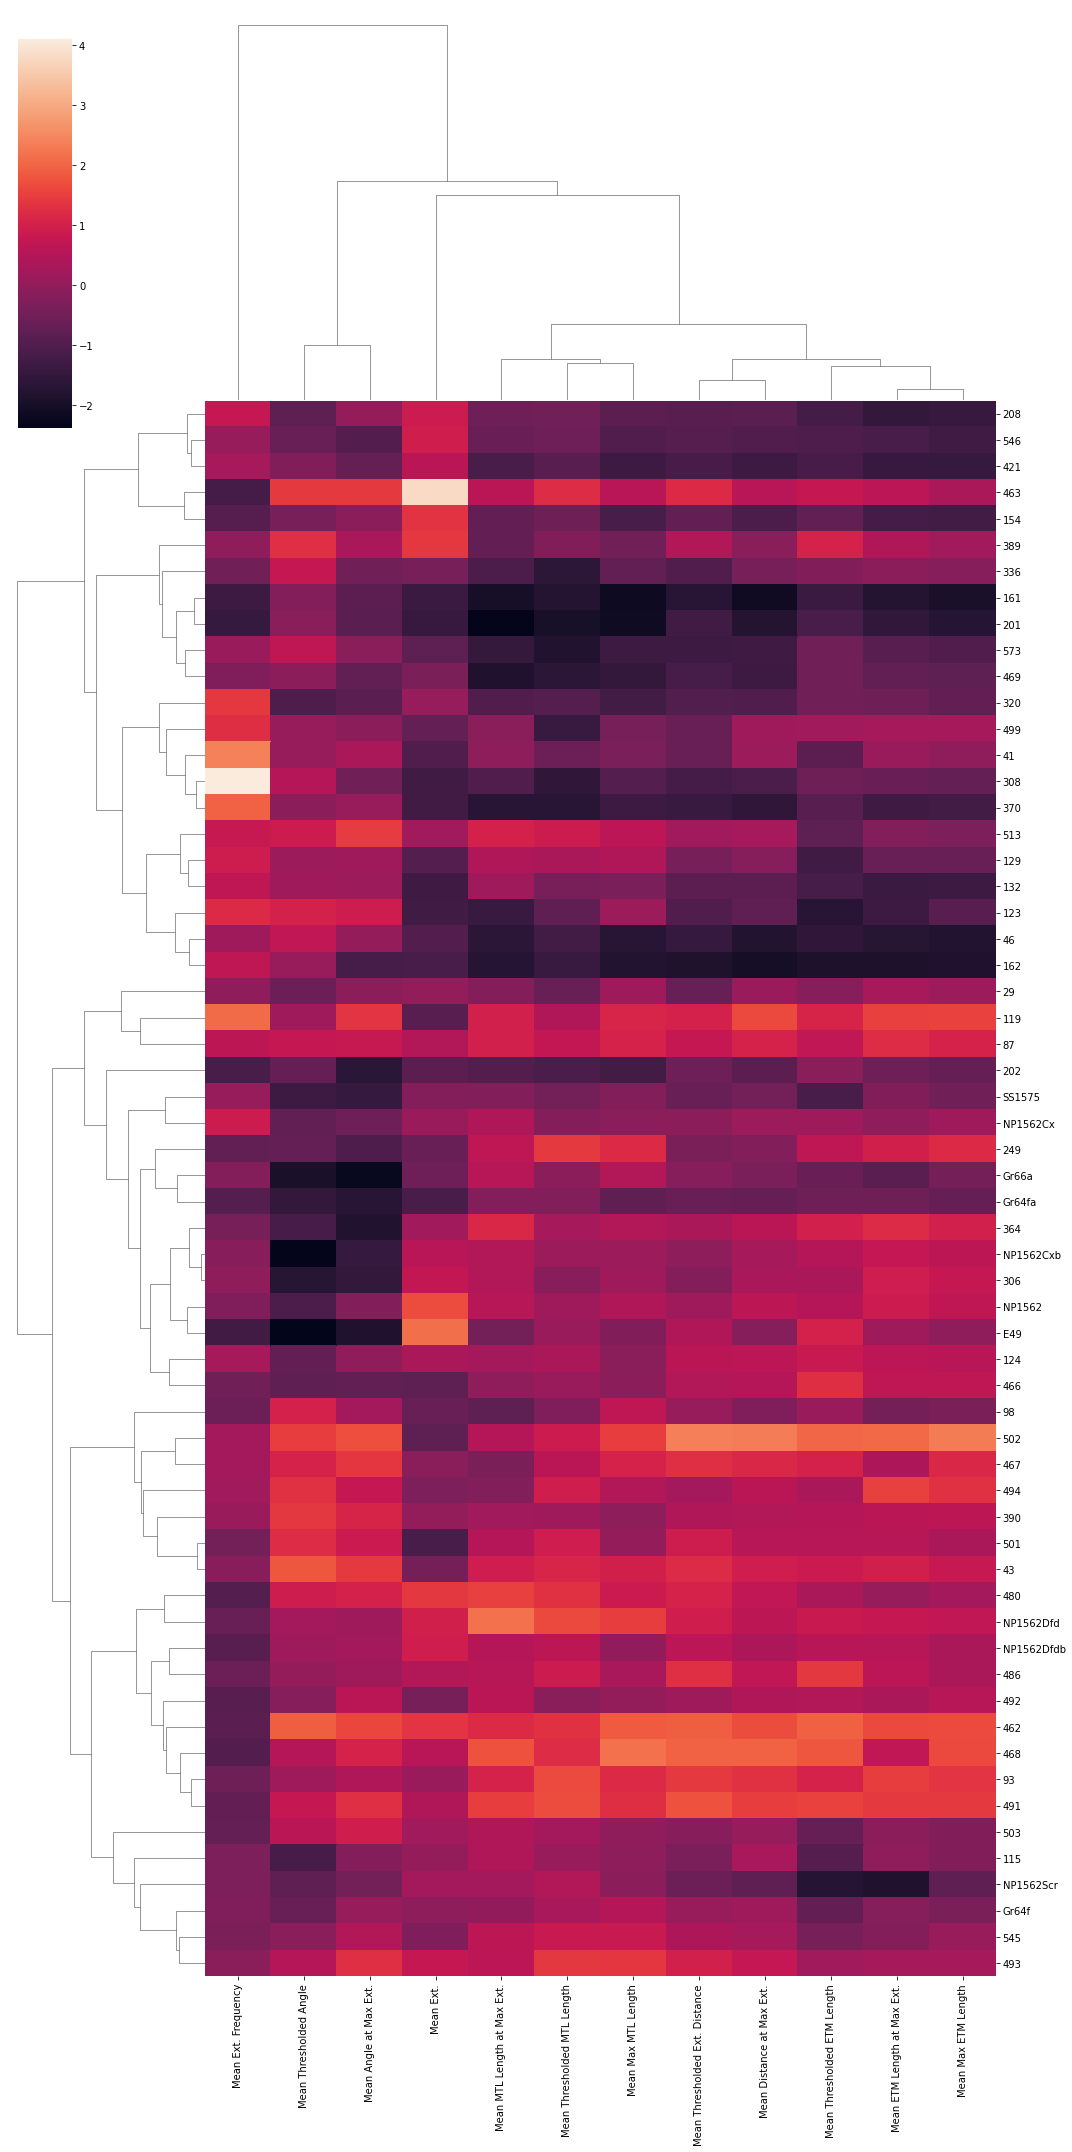

In [ ]:
#How do each of these values correlate with each other?
sns.clustermap(processed_data, metric = 'correlation',
               z_score=1, figsize = (15,30)) #z-score 1 means column


In [ ]:
z_scores

,Mean Ext._zscore,Mean Thresholded Ext. Distance_zscore,Mean Thresholded Angle_zscore,Mean Ext. Frequency_zscore,Mean Angle at Max Ext._zscore,Mean Distance at Max Ext._zscore,Mean ETM Length at Max Ext._zscore,Mean MTL Length at Max Ext._zscore,Mean Thresholded ETM Length_zscore,Mean Thresholded MTL Length_zscore,Mean Max ETM Length_zscore,Mean Max MTL Length_zscore
SS1575,-0.218505,-0.643352,-1.353803,0.071415,-1.463688,-0.458935,-0.260903,-0.232539,-1.118310,-0.468520,-0.477544,-0.227456
513,0.216746,0.233131,0.892582,0.823364,1.485517,0.309503,-0.228711,1.042078,-0.790231,0.888605,-0.303678,0.631226
Gr66a,-0.539469,-0.191940,-1.947391,-0.221941,-2.252298,-0.353911,-0.839578,0.562319,-0.626629,-0.105208,-0.448396,0.492389
463,3.836823,1.190031,1.455145,-1.202588,1.456096,0.579115,0.620303,0.607574,0.792314,1.243174,0.357443,0.587118
NP1562,1.711227,0.167888,-1.078118,-0.285619,-0.242383,0.656235,0.890766,0.555391,0.494223,0.195524,0.684719,0.436151
93,0.125397,1.437812,0.186722,-0.563192,0.463951,1.322424,1.493398,1.064145,1.077767,1.679844,1.371988,1.203134
249,-0.636495,-0.344545,-0.705315,-0.742797,-1.052508,-0.239192,0.983007,0.685241,0.679267,1.443290,1.189919,1.192294
Gr64f,-0.058390,0.091192,-0.639233,-0.297375,0.083145,0.206447,-0.193676,-0.007510,-0.730514,0.326969,-0.329430,0.513875
480,1.419901,1.060844,0.906291,-0.958324,1.029632,0.712550,0.078161,1.550379,0.378886,1.331599,0.246979,0.857556
124,0.369428,0.598099,-0.726324,0.306100,-0.023840,0.640661,0.638091,0.287247,0.831183,0.371936,0.591134,-0.135490


Perform principle component analysis of the processed data.

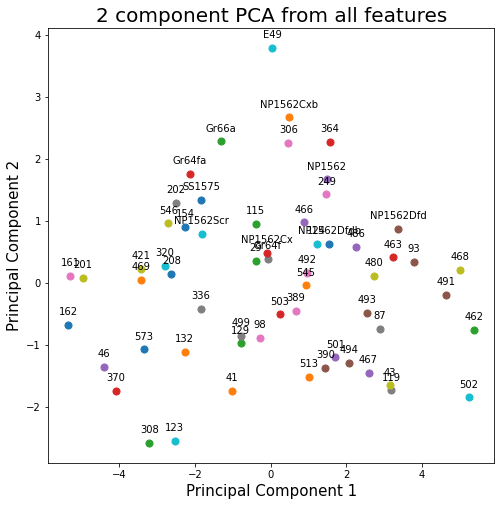

In [ ]:
features = processed_data.columns.to_list()
# Separating out the features
x = processed_data.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA from all features', fontsize = 20)
for i in range(len(list_of_neurons)):
        ax.scatter(principalDf.loc[i, 'principal component 1']
               , principalDf.loc[i, 'principal component 2']
               , 
                s = 50,)
        ax.annotate(list_of_neurons[i], # this is the text
                 (principalDf.loc[i, 'principal component 1'], principalDf.loc[i, 'principal component 2']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
plt.show()

Color the neurons based on what we already know about them.

In [ ]:
bitter_PEs = ['Gr66a', '545', 'NP1562','NP1562Cx','NP1562Cxb','NP1562Dfd','NP1562Dfdb','NP1562Scr','SS1575','306', '308']
half_extensions = ['46', '132', '161', '162', '208', '249', '320', '545', '546', '202', '469', '573']
proboscis_extends_labellum_opens = ['87', '93', '468', '115', '119', '43', 'Gr64f', 'Gr64fa', '492', '502']
proboscis_stays_extended = ['463', '486', '493', '545', '389', '390', 'E49']
proboscis_extends_no_labellum = ['463', '486', '501', '513', '499', '503']
same_neurons = [['41', '43'], ['115', '119', '124'], ['129', '132'], ['161', '162'], ['201', '202'], ['389', '390'], ['462', '463'], ['93', '467', '468'], ['491', '492', '494'], ['499', '503a', '503b']]
second_order_neurons = {'41', '43', '87', '115', '119', '124', '389', '390', '499', '501', '502', '503', '513'}
dopamine_modulation = {'462', '463'}
third_order_potential_premotor_neurons = {'491', '492', '494', '132', '129'}
motor_neurons ={'E49'}
hunger_neurons = {'466', '348', '349', '29', '44', '46', '87', '426', '431', '433', '436', '439', '441', '462', '463', '486'}

In [ ]:
color_same_neurons = [0] * len(list_of_neurons)
color_neuron_function = [0] * len(list_of_neurons)
color_hunger_neurons = [0] * len(list_of_neurons)
function_labels = ['unknown'] * len(list_of_neurons)
for i in range(len(list_of_neurons)):
  neuron = list_of_neurons[i]
  if (neuron in second_order_neurons):
    color_neuron_function[i] = 1
    function_labels[i] = 'second order neuron'
  if (neuron in hunger_neurons):
    color_hunger_neurons[i] = 1
    
  if (neuron in dopamine_modulation):
    color_neuron_function[i] = 2
    function_labels[i] = 'dopamine modulation'
  if (neuron in third_order_potential_premotor_neurons):
    color_neuron_function[i] = 3
    function_labels[i] = 'third order potential premotor neuron'
  if (neuron in motor_neurons):
    color_neuron_function[i] = 4
    function_labels[i] = 'motor neuron'
  if (neuron == '41' or neuron == '43'):
    color_same_neurons[i] = 1
  if (neuron == '115' or neuron == '119' or neuron == '124'):
    color_same_neurons[i] = 2
  if (neuron == '129' or neuron == '132'):
    color_same_neurons[i] = 3
  if (neuron == '161' or neuron == '162'):
    color_same_neurons[i] = 4
  if (neuron == '201' or neuron == '202'):
    color_same_neurons[i] = 5
  if (neuron == '389' or neuron == '390'):
    color_same_neurons[i] = 6
  if (neuron == '462' or neuron == '463'):
    color_same_neurons[i] = 7
  if (neuron == '93' or neuron == '467' or neuron == '468'):
    color_same_neurons[i] = 8
  if (neuron == '491' or neuron == '492' or neuron == '494'):
    color_same_neurons[i] = 9
  if (neuron == '499' or neuron == '503'):
    color_same_neurons[i] = 10


In [ ]:
FUNCTION_COLOR_MAP = {0 : 'gray',
                   1 : 'g',
                   2 : 'c',
                   3 : 'm',
                   4 : 'darkorange'}
HUNGER_COLOR_MAP = {0 : 'gray',
                   1 : 'r'}
SAME_COLOR_MAP = {0 : 'gray',
                   1 : 'g',
                   2 : 'b',
                   3 : 'c',
                   4 : 'm',
                   5 : 'y',
                   6 : 'r',
                   7 : 'darkorange',
                  8 : 'indigo',
                  9 : 'hotpink',
                  10 : 'tab:brown'}

In [ ]:
function_color = [FUNCTION_COLOR_MAP[l] for l in color_neuron_function]
same_color = [SAME_COLOR_MAP[l] for l in color_same_neurons]
hunger_color = [HUNGER_COLOR_MAP[l] for l in color_hunger_neurons]

In [ ]:
np.array(principalDf['principal component 1'])

array([-1.83792917,  1.00243726, -1.32784056,  3.24000596,  1.47626295,
        3.77438586,  1.47134492, -0.07320499,  2.73332338,  1.21958725,
       -2.25858544,  0.92257114, -0.40118709,  0.24407569,  1.70390625,
        2.54140375, -0.29357497,  3.19210959,  3.14252567, -1.82908149,
       -2.62627445, -1.02428717, -0.79305771, -0.10903289, -4.40284689,
        3.37360957, -5.30191596,  2.87953514, -2.70480856, -2.5426778 ,
       -5.35313343, -2.27873183,  5.37495023,  1.56771817,  0.87580917,
        1.44703715,  0.67278401, -1.84220267, -3.41762709,  0.03573252,
        1.54976767,  0.47093634, -3.20952103, -2.13279156,  2.25053448,
        4.62564305,  0.96226157, -0.78147182,  4.99130712,  5.22941244,
       -3.35387521, -3.42509376, -0.3886429 , -4.10345645,  2.58606006,
        2.05916293,  0.46411652, -2.50729366, -4.96991525, -2.79025601])

(array([ 3, 32]),)
(array([39]),)
(array([ 1,  9, 12, 13, 14, 17, 18, 21, 27, 35, 36, 47, 49]),)
(array([ 0,  2,  4,  5,  6,  7,  8, 10, 11, 15, 16, 19, 20, 23, 24, 25, 26,
       28, 29, 30, 33, 34, 37, 38, 40, 41, 42, 43, 44, 48, 50, 51, 52, 53,
       54, 56, 57, 58, 59]),)
(array([22, 31, 45, 46, 55]),)


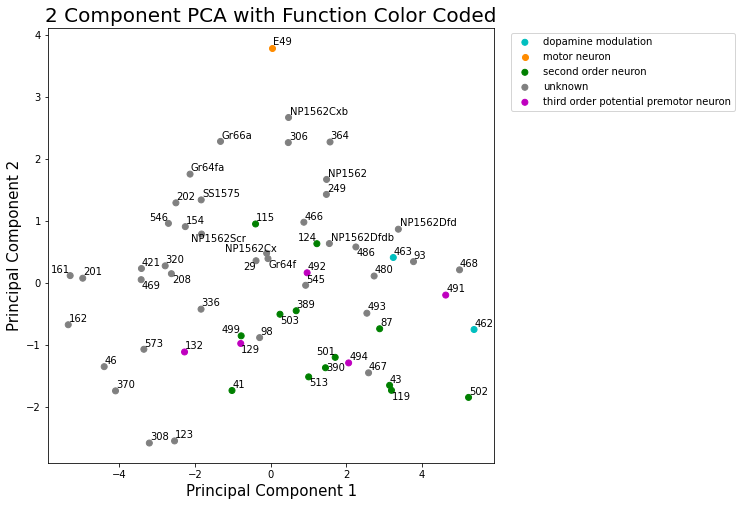

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA with Function Color Coded', fontsize = 20)
# function_scatter = ax.scatter(principalDf['principal component 1']
#                , principalDf['principal component 2']
#                , 
#                 c = function_color)
group = np.array(function_color)
for g in np.unique(group):
    ix = np.where(group == g)
    print(ix)
    ax.scatter(np.array(principalDf['principal component 1'])[ix],np.array(principalDf['principal component 2'])[ix], c = np.array(function_color)[ix], label = np.array(function_labels)[ix])

texts = []
for i, txt in enumerate( list_of_neurons ):
    texts.append(ax.text(principalDf.loc[i, 'principal component 1'], principalDf.loc[i, 'principal component 2'], txt))
adjust_text(texts)
plt.legend(labels=['dopamine modulation', 'motor neuron', 'second order neuron', 'unknown', 'third order potential premotor neuron'], bbox_to_anchor=(1.55, 1))
plt.show()

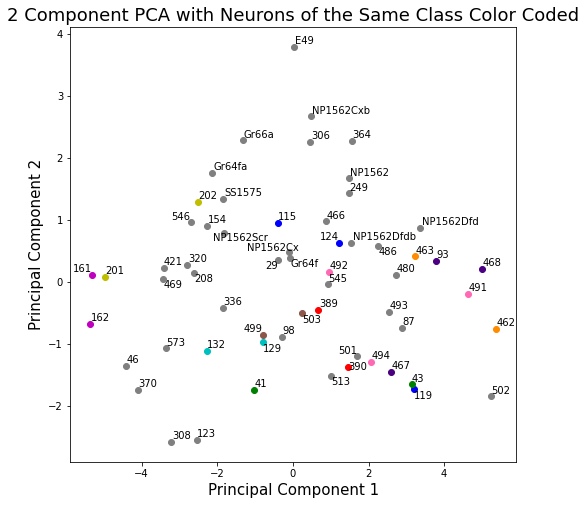

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA with Neurons of the Same Class Color Coded', fontsize = 18)
for i in range(len(list_of_neurons)):
        ax.scatter(principalDf.loc[i, 'principal component 1']
               , principalDf.loc[i, 'principal component 2']
               , 
                c = same_color[i])
texts = []
for i, txt in enumerate( list_of_neurons ):
    texts.append(ax.text(principalDf.loc[i, 'principal component 1'], principalDf.loc[i, 'principal component 2'], txt))
adjust_text(texts)
plt.show()

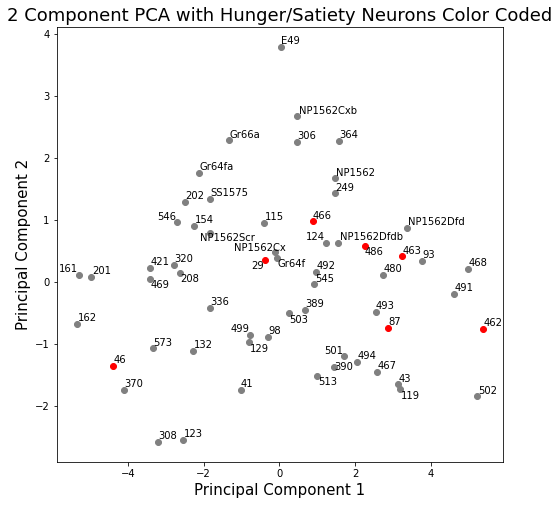

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA with Hunger/Satiety Neurons Color Coded', fontsize = 18)
for i in range(len(list_of_neurons)):
        ax.scatter(principalDf.loc[i, 'principal component 1']
               , principalDf.loc[i, 'principal component 2']
               , 
                c = hunger_color[i])
texts = []
for i, txt in enumerate( list_of_neurons ):
    texts.append(ax.text(principalDf.loc[i, 'principal component 1'], principalDf.loc[i, 'principal component 2'], txt))
adjust_text(texts)
plt.show()

[-1.83792917  1.00243726 -1.32784056  3.24000596  1.47626295  3.77438586
  1.47134492 -0.07320499  2.73332338  1.21958725 -2.25858544  0.92257114
 -0.40118709  0.24407569  1.70390625  2.54140375 -0.29357497  3.19210959
  3.14252567 -1.82908149 -2.62627445 -1.02428717 -0.79305771 -0.10903289
 -4.40284689  3.37360957 -5.30191596  2.87953514 -2.70480856 -2.5426778
 -5.35313343 -2.27873183  5.37495023  1.56771817  0.87580917  1.44703715
  0.67278401 -1.84220267 -3.41762709  0.03573252  1.54976767  0.47093634
 -3.20952103 -2.13279156  2.25053448  4.62564305  0.96226157 -0.78147182
  4.99130712  5.22941244 -3.35387521 -3.42509376 -0.3886429  -4.10345645
  2.58606006  2.05916293  0.46411652 -2.50729366 -4.96991525 -2.79025601]


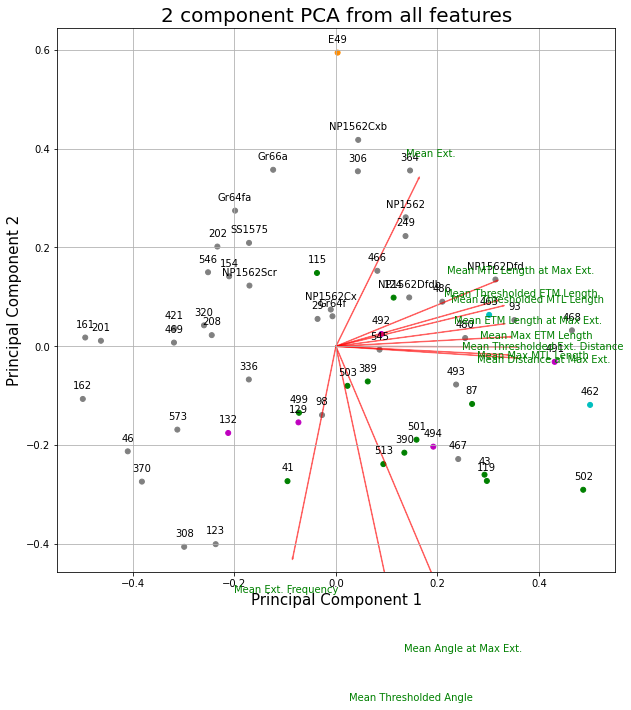

In [ ]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    print(xs)
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA from all features', fontsize = 20)
    ax.scatter(xs * scalex,ys * scaley,s=25,c=function_color)
    for i in range(len(list_of_neurons)):
        ax.annotate(list_of_neurons[i], # this is the text
                 (xs[i] * scalex, ys[i] * scaley), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    
    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    ax.grid()

myplot(principalComponents[:,0:2],np.transpose(pca.components_[0:2, :]),features)

plt.show()

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [12] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


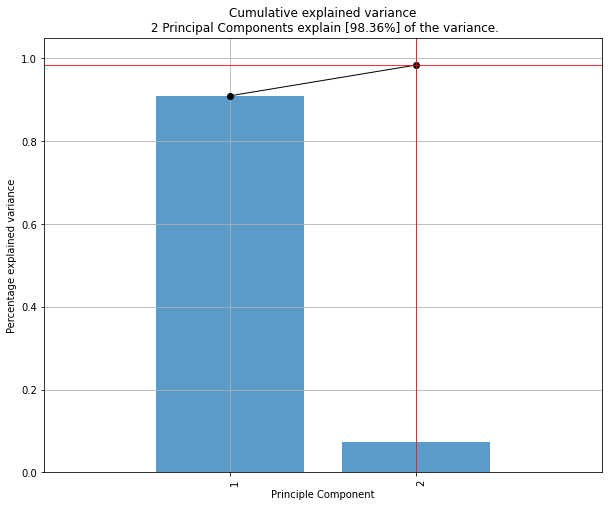

<Figure size 432x288 with 0 Axes>

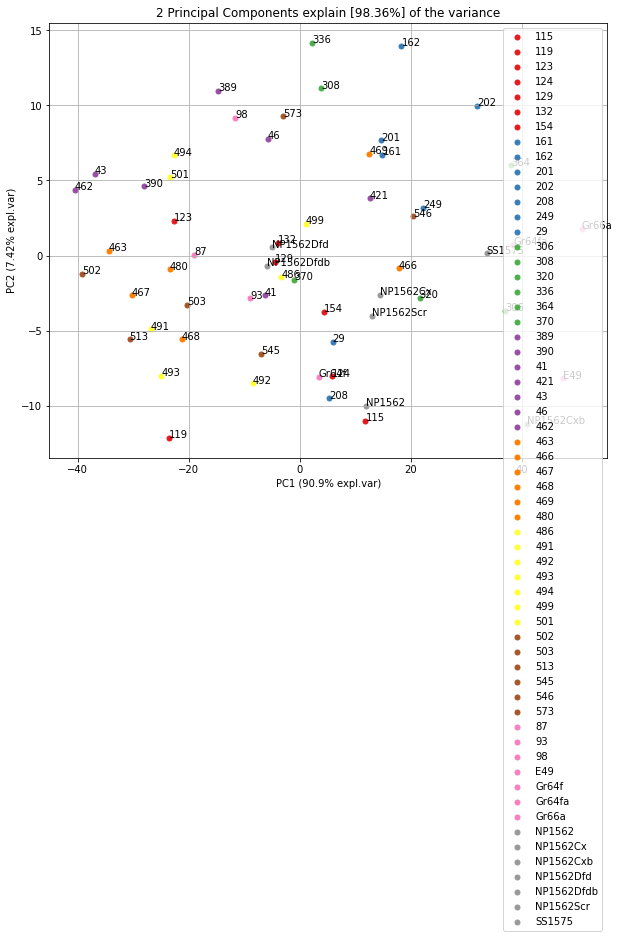

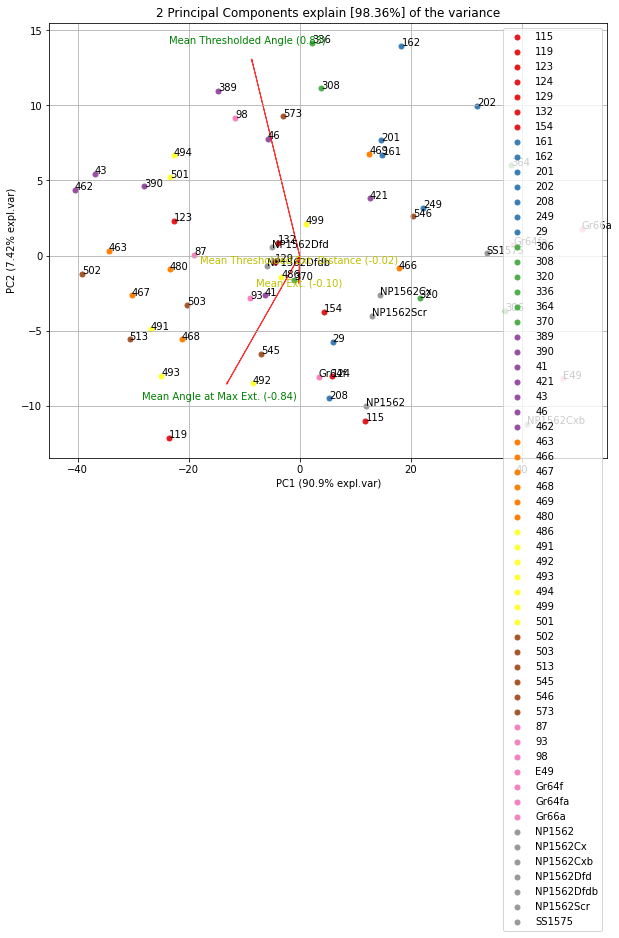

In [ ]:

# Or reduce the data towards 2 PCs
model = pca_program(n_components=2)

# Fit transform
results = model.fit_transform(processed_data)

# Plot explained variance
fig, ax = model.plot()

# Scatter first 2 PCs
fig, ax = model.scatter()

# Make biplot with the number of features
fig, ax = model.biplot(n_feat=4)

plt.show()


Perform t-SNE on the data and plot this.

[t-SNE] Computing 59 nearest neighbors...
[t-SNE] Indexed 60 samples in 0.000s...
[t-SNE] Computed neighbors for 60 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 3.185697
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.846619
[t-SNE] KL divergence after 300 iterations: 1.087934


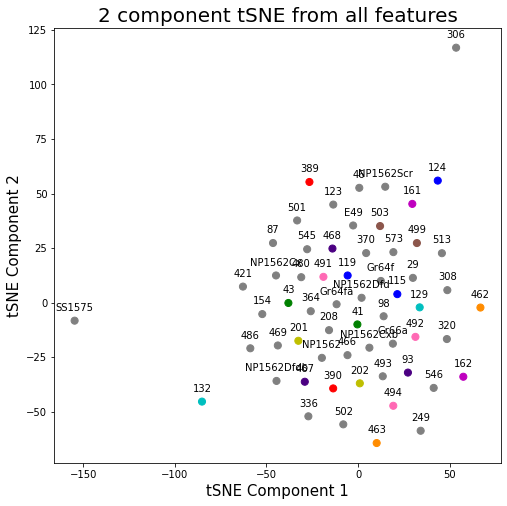

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)
tsneDf = pd.DataFrame(data = tsne_results, columns = ['tsne component 1', 'tsne component 2'])

tsneDf
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('tSNE Component 1', fontsize = 15)
ax.set_ylabel('tSNE Component 2', fontsize = 15)
ax.set_title('2 component tSNE from all features', fontsize = 20)
ax.scatter(tsneDf['tsne component 1']
               , tsneDf['tsne component 2']
               , 
                s = 50,
                c = same_color)
for i in range(len(list_of_neurons)):
        
        ax.annotate(list_of_neurons[i], # this is the text
                 (tsneDf.loc[i, 'tsne component 1'], tsneDf.loc[i, 'tsne component 2']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
plt.show()